# <font color= 'cornflowerblue'> Calibration to market option prices </font>

In [1]:
import pandas as pd
import numpy as np
import signatory
import os
from tqdm.auto import tqdm
import torch
import multi_moments as mm
from joblib import Parallel,delayed
import esig
import itertools as itt
from scipy.optimize import least_squares,minimize,minimize_scalar
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

def duplicate(testList, n):
    x=[list(testList) for _ in range(n)]
    flat_list = []
    for sublist in x:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def multi_maturities(maturities,k):
    mat=list(maturities)
    new_multi_mat=[]
    for element in mat:
        for j in range(k):
            new_multi_mat.append(element)
    return np.array(new_multi_mat)

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)    
#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF


#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def get_iv_from_calib(calibrated_prices,strikes,maturities):
    sig_prices_mc_arr=[]
    iv_calib_mc=[]
    
    sig_prices_mc_arr=np.array(np.split(calibrated_prices,len(maturities)))
        
    for j in range(len(maturities)):
        for k in range(len(strikes[j])):
                iv_calib_mc.append(implied_vol_minimize(sig_prices_mc_arr[j,k], initial_price, strikes[j][k], maturities[j], 0, payoff="call", disp=True))

    iv_calib_arr_mc=np.array([np.array(iv_calib_mc[k*len(strikes[0]):(k+1)*len(strikes[0])]) for k in range(len(maturities))])
    return iv_calib_arr_mc, sig_prices_mc_arr


def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1


def tilde_transformation(word):
    word_aux=word.copy()
    word_aux_2=word.copy()
    if word[-1]==1:
        word.append(2)
        word_aux.append(3)
        return word, word_aux
    if word[-1]!=1:
        word_aux.append(2)
        word_aux_2.append(3)
        word[-1]=1
        return word_aux, word_aux_2, word

def e_tilde_part2_new(words_as_lists):
    tilde=[list(tilde_transformation(words_as_lists[k])) for k in np.array(range(len(words_as_lists)))[1:]] #we skip the empty word
    return tilde

def from_tilde_to_strings_new(tilde): 
    for k in range(len(tilde)):
        if len(tilde[k])==2:
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
        elif (len(tilde[k])==3 and len(tilde[k][-1])==1):
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][-1]=str(tuple(tilde[k][-1])).replace(",","")
        elif len(tilde[k])==3:
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][2]=str(tuple(tilde[k][2])).replace(" ","")
    return tilde

def get_tilde_df_debug(Sig_data_frame,new_tilde,keys_n,keys_n1,comp_of_path,rho,y):
    aus_B=[]
    y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
    for k in range(len(y)):
        if k==0:
            aus_B.insert(0,Sig_data_frame['(2)'])
        if (k>0 and y[k][-1]==1):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]])
           
        if (k>0 and y[k][-1]==2):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]]-0.5*Sig_data_frame[new_tilde[k-1][2]])
        
        if (k>0 and y[k][-1]==3):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]]-rho*0.5*Sig_data_frame[new_tilde[k-1][2]])
           
    new_keys_B=[keys_n1[k]+str('~B') for k in range(len(y))]
    new_dictionary_B={key:series for key,series in zip(new_keys_B,aus_B)}        
    transformed_data_frame_B=pd.DataFrame(new_dictionary_B)
    return transformed_data_frame_B

def col_stack(element):
    return np.column_stack((element[0],element[1],element[2]))

def correlated_bms_correct(N,rho,t_final,t_0):
    time_grid=np.linspace(0,t_final,num=N,retstep=True)[0]
    dt=np.abs(time_grid[0]-time_grid[1])
    dB = np.random.normal(0, np.sqrt(dt), N)
    dB[0]=0
    dW = rho*dB+np.sqrt(1-(rho)**2)*np.random.normal(0,np.sqrt(dt),N)
    dW[0]=0
    B = np.cumsum(dB)
    W = np.cumsum(dW)
    return time_grid, B, W

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

### <font color= 'cornflowerblue'> Load data from the market </font>

In sequence we: 
* scale the strike prices to $S_{0}=1$
* scale the option prices to $S_{0}=1$
* display the implied volatility on the market, given by only Call Option on the SPX index

In [3]:
moneyness=np.load('strikes_SPX_Bloomberg.npy')
maturities=np.load('maturities_SPX_Bloomberg.npy')
iv_market=np.load('iv_spx_170321_bymat.npy')
market_prices=np.load('prices_optionsSPX_170321.npy')

initial_price=100
strikes_all=duplicate(moneyness*initial_price,len(maturities))
strikes=np.array([np.array(strikes_all[j*(len(moneyness)):(j+1)*(len(moneyness))]) for j in range(len(maturities))])
maturities_ext=multi_maturities(maturities,len(strikes[0]))
strike_flat=strikes.flatten()
option_prices_splitted=np.array(np.split(market_prices,len(maturities)))

prices_scaled=option_prices_splitted/100
strikes=strikes/100

In [4]:
initial_price=1


if initial_price==100:
    Premium=market_prices
elif initial_price==1:
    Premium=prices_scaled.flatten()

In [5]:
maturities[0]

0.08487337440109514

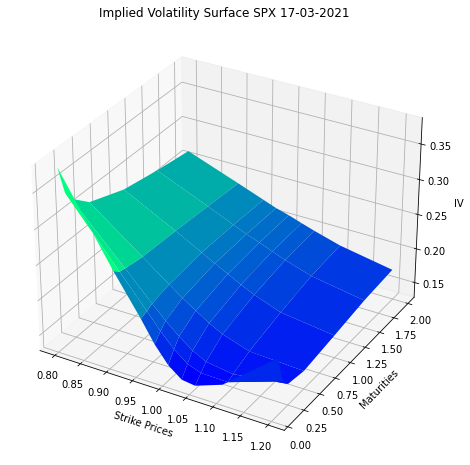

In [6]:
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(len(maturities))])

%matplotlib inline
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')


ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1,
                cmap=cm.winter,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strike Prices')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surface SPX 17-03-2021');

### <font color= 'cornflowerblue'> Compute the Vega weights if bid-ask spreads are not available </font>

In [7]:
initial_price=1

In [8]:
def get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation):
    vega=[]
    for i in range(len(maturities)):
        for j in range(len(strikes[i])):
            if flag_truncation==True:
                vega.append(min(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])),1))
            else:
                vega.append(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])))
    vega=np.array(vega)

    vega_by_mat=np.array(np.split(vega,len(maturities)))
    sums_each_strike=np.sum(vega_by_mat, axis=1)
    normalized_vega=np.array([vega_by_mat[j]/sums_each_strike[j] for j in range(len(maturities))])
    flat_normal_weights=normalized_vega.flatten()
    return flat_normal_weights, normalized_vega


flag_truncation=False
flat_normal_weights, norm_vegas=get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation)

In [9]:
def one_step_MC_mat_truncation_last(rho,n,maturity):
    '''
    Inputs:
    rho (float): number in (-1,1), correlation coefficient of the sampled Brownians
    n (int): order of truncation of the Signature Model under Q
    list_of_maturities (list): list of floats, where each float is a maturity
    
    Output:
    Pandas Data Frame of the tilde-Signature of the Brownian driving the price
    '''
    N=int(maturity*365.25)
    time_and_bms=correlated_bms_correct(N,rho,maturity,0)
    augmented_bms=col_stack(time_and_bms)
    augmented_bms=torch.from_numpy(augmented_bms).unsqueeze(0)
    sig=signatory.signature(augmented_bms,n+1,stream=True,basepoint=True,scalar_term=True)
    nbr_components=augmented_bms.shape[-1]
    keys_n1=esig.sigkeys(nbr_components,n+1).strip().split(" ")
    keys_n=esig.sigkeys(nbr_components,n).strip().split(" ")
    y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
    first_step=e_tilde_part2_new(y)
    new_tilde=from_tilde_to_strings_new(first_step)
    sig_df=pd.DataFrame(sig.squeeze(0).numpy(), columns=keys_n1)
    tilde_sig_df=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys_n1,nbr_components,rho,y)
    tilde_sig_df_by_mat=np.array(tilde_sig_df.iloc[-1,:])
    
    return tilde_sig_df_by_mat

In [10]:
MC_number, rho, n= 100, -0.5,2
rho_matrix=[[1,rho],[rho,1]]
d,D=2,1

In [11]:
grid=np.array([int(T*365.25) for T in maturities])
maturity_dict=dict(zip(maturities, grid.T))
maturity_dict

nbr_components=len(rho_matrix)+1
keys_n1=esig.sigkeys(nbr_components,n+1).strip().split(" ")
keys_n=esig.sigkeys(nbr_components,n).strip().split(" ")
y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
first_step=e_tilde_part2_new(y)
new_tilde=from_tilde_to_strings_new(first_step)

def auxiliar_function(idx_mat,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict):
    'Observe that this function is similar to one_step_MC_mat_truncation_last '
    'but it takes out the preparation to the tilde transformation on the data frame,'
    'the output is the same'
    time_and_bms=correlated_bms_correct(maturity_dict[maturities[idx_mat]],rho,maturities[idx_mat],0)
    augmented_bms=col_stack(time_and_bms)
    augmented_bms=torch.from_numpy(augmented_bms).unsqueeze(0)
    sig=signatory.signature(augmented_bms,n+1,stream=True,basepoint=True,scalar_term=True)
    sig_df=pd.DataFrame(sig.squeeze(0).numpy(), columns=keys_n1)
    tilde_sig_df=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys_n1,nbr_components,rho,y)
    tilde_sig_df_by_mat=np.array(tilde_sig_df.iloc[-1,:])
    return tilde_sig_df_by_mat

def auxiliar_function_all_mat(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict):
    'Auxiliar function to parallelize the previous for avery maturity'
    get_model=[auxiliar_function(j,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for j in range(len(maturities))]
    #Parallel(n_jobs=?)(delayed(auxiliar_function)(j,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for j in range(len(maturities)))
    get_model=np.array(get_model)
    return get_model

get_model=auxiliar_function_all_mat(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict)
arr_dfs_bymat=np.array(Parallel(n_jobs=-1)(delayed(auxiliar_function_all_mat)(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for k in tqdm(range(MC_number),desc='Getting Tilde-Sig of the Brownians at all maturities')))


Getting Tilde-Sig of the Brownians at all maturities:   0%|          | 0/100 [00:00<?, ?it/s]

Observe that the output $\textit{arr_dfs_by_mat}$ has the shape $(MC,r,p)$ with
* $MC$ the number of Monte Carlo simulations
* $r$ the number of maturities
* $p$ the number of components of the tilde signature, namely $\# \{ \tilde{I}: \lvert \tilde{I} \lvert \le n\}$ 

In [12]:
arr_dfs_bymat.shape

(100, 7, 13)

## <font color='cornflowerblue'> Calibration to a set of selected maturities' slice </font>

Select the desired maturities, and thus the corresponding vega weights and option prices

In [13]:
index_sel_maturities=[0,1]
sel_maturities=[maturities[0],maturities[1]]
Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices_scaled,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

In [14]:
def get_mc_sel_mat_tensor(l):
    '''
    Input: l (np.array): a set of parameters of the model, mind the dimension
    Output: Monte Carlo prices of the model with parameters l for the selected maturities
    '''
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
    pay=[]
    for K in strikes[0]:
        matrix_big=[]
        for j in index_sel_maturities:
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr

In [15]:
l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))

In [16]:
def obj_MC_tensor_selected_mat(l):
    mc_payoff_arr=get_mc_sel_mat_tensor(l)   
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)

In [494]:
#Optimization routine, stores the ell* in the folder 

for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,int(((d+1)**(n+1)-1)*D/d))
    res1 = least_squares(obj_MC_tensor_selected_mat, l_initial,loss='linear')

#np.save(f'ell_MC({n},{m},{d},{rho},{MC_number},{initial_price},{index_sel_maturities}).npy',res1['x'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [495]:
calibrated_prices=get_mc_sel_mat_tensor(res1['x'])
#np.save(f'calibrated_prices_MC({MC_number},{initial_price},{index_sel_maturities})',calibrated_prices)

In [69]:
iv_, prices_= get_iv_from_calib(calibrated_prices,strikes,sel_maturities)

# <font color= 'cornflowerblue'>Time-varying parameters</font>

We here considere a variant of the starting model which is still a continuous model, but we allow the parameters to depend on the maturity we aim to fit on the market. Let $r\ge1$ and $\mathcal{T}:=\{T_{1},\dots,T_{r}\}$ be a set of fixed time, e.g. maturity on the market, then the model with time-varying parameters reads as follows for the first maturity:
\begin{equation*}
    S_{T_{1}}(\ell)_{n+1}:=S_{0}+\sum_{| I | \le n}\ell_{I}(T_{1})\langle \tilde{e}_{I},\widehat{\mathbb{W}}_{T_{1}}\rangle
\end{equation*}
and for $1<k\le r$:
\begin{equation*}
    S_{T_{k}}(\ell)_{n+1}:=S_{0}+\sum_{| I | \le n}\ell_{I}(T_{1})\langle \tilde{e}_{I},\widehat{\mathbb{W}}_{T_{k}}\rangle+\sum_{j=1}^{k}\sum_{| I | \le n}\ell_{I}(T_{j+1})\langle \tilde{e}_{I},\widehat{\mathbb{W}}_{T_{k}}-\widehat{\mathbb{W}}_{T_{j}}\rangle
\end{equation*}

In [14]:
arr_dfs_by_mat_loaded=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')

In [15]:
arr_dfs_by_mat=np.swapaxes(arr_dfs_by_mat_loaded,0,1)

In [16]:
j=0
sel_maturities=[maturities[j]]
index_sel_maturities=[j]
Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(Premium,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

if j>0:
    adjusted_arr_dfs=[arr_dfs_by_mat[:,j,:]-arr_dfs_by_mat[:,idx,:] for idx in range(0,j-1)]
    adjusted_arr_dfs.insert(0,arr_dfs_by_mat[:,j,:])
    adjusted_arr_dfs=np.array(adjusted_arr_dfs)
    arr_dfs_to_optimize=arr_dfs_by_mat[:,j,:]-arr_dfs_by_mat[:,j-1,:]
    adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],l_calibrated[k],axes=1) for k in range(j)])
    adjusted_scalar_products=adjusted_scalar_products.transpose()
elif j==0:
    arr_dfs_to_optimize=[]
    adjusted_scalar_products=[]


In [110]:
n, d, D = 2, 2, 1

In [17]:
def time_varying_model(l,idx_maturity,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price):
    if idx_maturity==0:
        tensor_sigsde_at_mat_aux=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
        tensor_sigsde_at_mat=tensor_sigsde_at_mat_aux[:,0]
    else:
        tensor_prod_last_maturity=np.tensordot(arr_dfs_to_optimize,l,axes=1)
        tensor_prod_last_maturity=np.expand_dims(tensor_prod_last_maturity,1)
        tensor_sigsde_at_mat_aux=np.concatenate((adjusted_scalar_products,tensor_prod_last_maturity),axis=1)
        tensor_sigsde_at_mat=initial_price+np.sum(tensor_sigsde_at_mat_aux,axis=1)
    return tensor_sigsde_at_mat

def get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes):

    '''
    Input: tensor_sigsde_mat (np.array): model at selected maturities

    If len(index_sel_maturities)>1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim, len(index_sel_maturities))
    If len(index_sel_maturities)>1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim,)

    index_sel_maturities (list): list of integers corresponding to the selected maturities
    strikes (np.array 2D): array of arrays where each of the sub-array stores the strikes

    Output: Monte Carlo prices of the model for the selected maturities and strikes
    '''
    pay=[]
    if len(index_sel_maturities)==1:

        for K in strikes[0]:
            matrix=np.maximum(0,tensor_sigsde_at_mat-K)
            pay.append(np.mean(matrix))
        mc_payoff_arr=np.array(pay)
    else:
        for K in strikes[0]:
            matrix_big=[]
            for j in index_sel_maturities:
                payff=np.maximum(0, tensor_sigsde_at_mat[:,j] - K)
                matrix_big.append(payff)
            matrix=np.array(matrix_big)
            pay.append(np.mean(matrix,axis=1))
        mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr

In [18]:
l=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))

In [118]:
tensor_sigsde=time_varying_model(l,index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)
mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)

In [139]:
cv_param=[]
for j in tqdm(range(100)):
    l=np.random.uniform(-0.4,0.4,int(((d+1)**(n+1)-1)*D/d))
    tensor_sigsde=time_varying_model(l,index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)
    if np.sum(mc_payoff_arr>Premium1)==len(Premium1):
        print('Whoaa one was found')
        cv_param.append(l)

  0%|          | 0/100 [00:00<?, ?it/s]

Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found
Whoaa one was found


In [158]:
def compare(l):
    tensor_sigsde=time_varying_model(l,index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)
    return np.linalg.norm(get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)-Premium1),l

In [159]:
x=[compare(ells) for ells in cv_param]

In [169]:
xx=sorted(x,key=itemgetter(0))

In [164]:
tensor_sigsde=time_varying_model(x[3][1],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)
get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)

array([0.20089961, 0.10755473, 0.06810485, 0.05158056, 0.0376249 ,
       0.02636092, 0.01771991, 0.00707181, 0.00073915])

In [165]:
Premium1

array([2.00826042e-01, 1.02704806e-01, 5.62723972e-02, 3.49450482e-02,
       1.74978630e-02, 6.49521100e-03, 1.98582114e-03, 2.06316838e-04,
       2.61561139e-05])

In [886]:
l_calibrated=[]
#calib_p=[]

for j in range(len(maturities)):
    sel_maturities=[maturities[j]]  
    index_sel_maturities=[j] 
    
    Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
    Premium1=np.array([np.split(Premium,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
    
    if j>0:
        adjusted_arr_dfs=[arr_dfs_by_mat[:,j,:]-arr_dfs_by_mat[:,idx,:] for idx in range(0,j-1)]
        adjusted_arr_dfs.insert(0,arr_dfs_by_mat[:,j,:])
        adjusted_arr_dfs=np.array(adjusted_arr_dfs)
        arr_dfs_to_optimize=arr_dfs_by_mat[:,j,:]-arr_dfs_by_mat[:,j-1,:]
        adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],l_calibrated[k],axes=1) for k in range(j)])
        adjusted_scalar_products=adjusted_scalar_products.transpose()
    elif j==0:
        arr_dfs_to_optimize=[]
        adjusted_scalar_products=[]

       
    def time_varying_model(l,idx_maturity,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price):
        if idx_maturity==0:
            tensor_sigsde_at_mat_aux=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
            tensor_sigsde_at_mat=tensor_sigsde_at_mat_aux[:,0]
        else:
            tensor_prod_last_maturity=np.tensordot(arr_dfs_to_optimize,l,axes=1)
            tensor_prod_last_maturity=np.expand_dims(tensor_prod_last_maturity,1)
            tensor_sigsde_at_mat_aux=np.concatenate((adjusted_scalar_products,tensor_prod_last_maturity),axis=1)
            tensor_sigsde_at_mat=initial_price+np.sum(tensor_sigsde_at_mat_aux,axis=1)
        return tensor_sigsde_at_mat
    
    def get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes):

        '''
        Input: tensor_sigsde_mat (np.array): model at selected maturities

        If len(index_sel_maturities)>1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim, len(index_sel_maturities))
        If len(index_sel_maturities)>1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim,)

        index_sel_maturities (list): list of integers corresponding to the selected maturities
        strikes (np.array 2D): array of arrays where each of the sub-array stores the strikes

        Output: Monte Carlo prices of the model for the selected maturities and strikes
        '''
        pay=[]
        if len(index_sel_maturities)==1:

            for K in strikes[0]:
                matrix=np.maximum(0,tensor_sigsde_at_mat-K)
                pay.append(np.mean(matrix))
            mc_payoff_arr=np.array(pay)
        else:
            for K in strikes[0]:
                matrix_big=[]
                for j in index_sel_maturities:
                    payff=np.maximum(0, tensor_sigsde_at_mat[:,j] - K)
                    matrix_big.append(payff)
                matrix=np.array(matrix_big)
                pay.append(np.mean(matrix,axis=1))
            mc_payoff_arr=np.array(pay).transpose().flatten()
        return mc_payoff_arr



    def obj_MC_tensor_selected_mat_TV(l):
        tensor_sigsde=time_varying_model(l,index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)
        mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)   
        return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)
   
    for t in tqdm(range(1),desc='Fit the maturity nbr. '+str(j+1)): 
        l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))
        res1 = least_squares(obj_MC_tensor_selected_mat_TV, l_initial,loss='linear')
    
    l_calibrated.append(res1['x'])
    
    #np.save(f'ell_MC_TV2({n},{d},{rho},{MC_number},{initial_price},{index_sel_maturities}).npy',res1['x'])
    
    tensor_sigsde_at_mat=time_varying_model(res1['x'],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price)   
    calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)
    #calib_p.append(calibrated_prices)
    
    
    #plt.plot(strikes,calib_p[-1])
    #plt.show()
    #print('Calibrated prices at maturity T={}'.format(round(maturities[j],4)),calib_p[-1])
    #np.save(f'calibrated_prices_MC_TV2({MC_number},{initial_price},{index_sel_maturities},{n})',calibrated_prices)
    

# <font color= 'cornflowerblue'> Load Calibration results for the time-varying model</font>

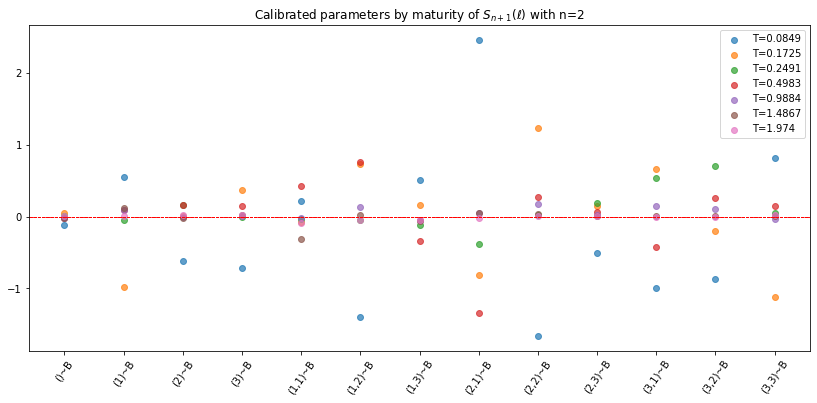

In [17]:
n=2
MC=1000000
rho=-0.5
initial_price=1

set_of_calibrated_prices=[]
for j in range(len(maturities)):
    if j==0:
        set_of_calibrated_prices.append(np.load(f'calibrated_prices_MC({MC},{initial_price},[{j}],{n}).npy'))
    else:
        set_of_calibrated_prices.append(np.load(f'calibrated_prices_MC_TV4({MC},{initial_price},[{j}],{n}).npy'))
set_of_calibrated_prices=np.array(set_of_calibrated_prices)
set_of_calibrated_params=[]
for j in range(len(maturities)):
    if j==0:
        set_of_calibrated_params.append(np.load(f'ell_MC({n},2,{rho},{MC},{initial_price},[{j}]).npy'))
    else:
        set_of_calibrated_params.append(np.load(f'ell_MC_TV4({n},2,{rho},{MC},{initial_price},[{j}]).npy'))
set_of_calibrated_params=np.array(set_of_calibrated_params)

chiavi=np.array([esig.sigkeys(3,n).strip('').split()[k]+str('~B') for k in range(set_of_calibrated_params.shape[1])])

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(14,6))
for j in range(len(maturities)):
    ax.axhline(y=0,color='r', linestyle='--',linewidth=0.8)
    if j==0:
        ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='o',alpha=0.7,label='T={}'.format(round(maturities[j],4)))
    else:
        ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='o',alpha=0.7,label='T={}'.format(round(maturities[j],4)))
    plt.setp(ax.get_xticklabels(), rotation=55)
    ax.set_title(r'Calibrated parameters by maturity of $S_{n+1}(\ell)$ with'+' n={}'.format(n)) #
ax.legend()
#plt.savefig('Parameters_TV_all_mat.png',dpi=800)
plt.show()

In [22]:
#for k in range(13):
#    plt.plot(np.cumsum(set_of_calibrated_params[:,k]),marker='o')
#    plt.show()

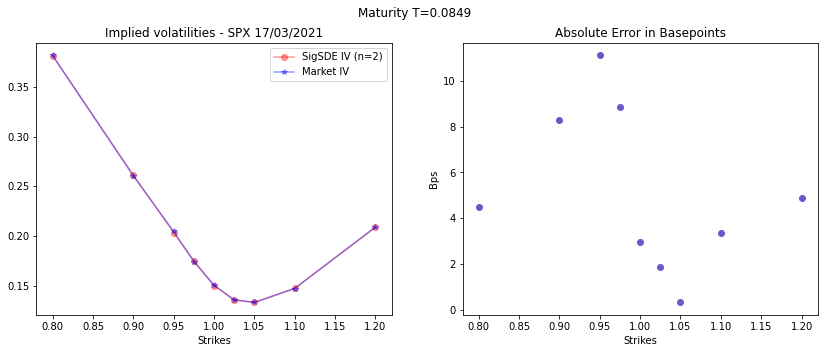

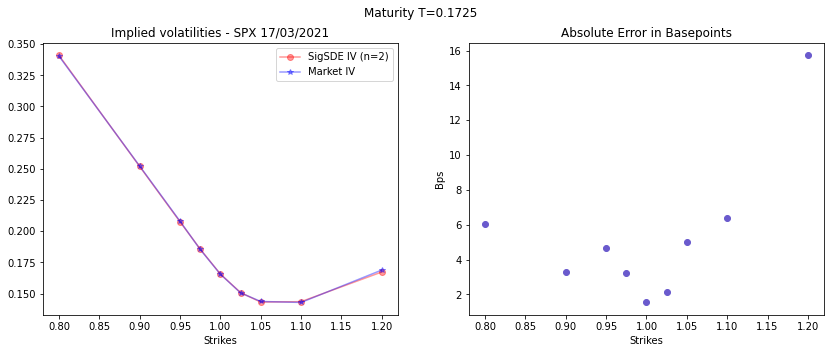

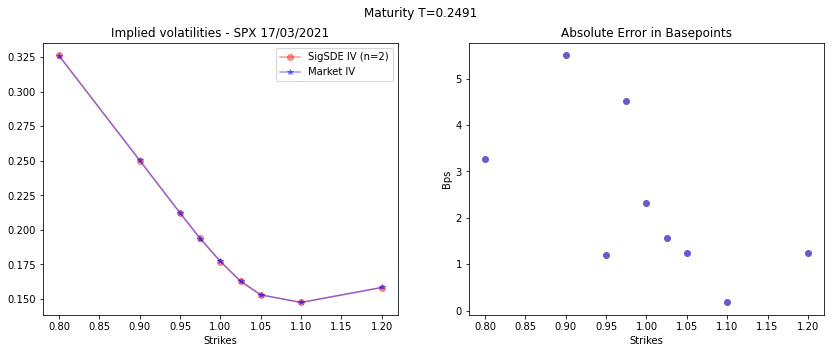

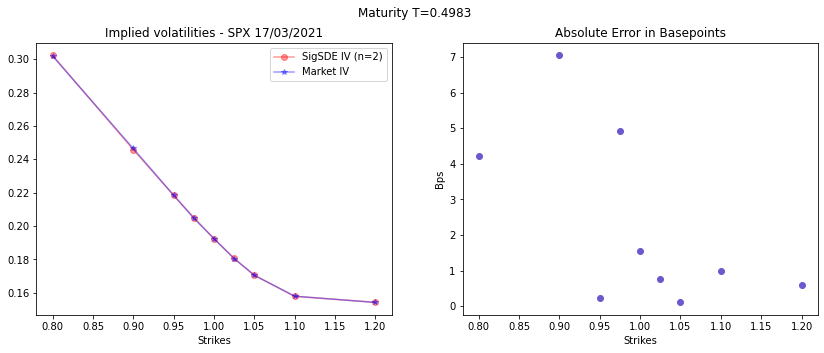

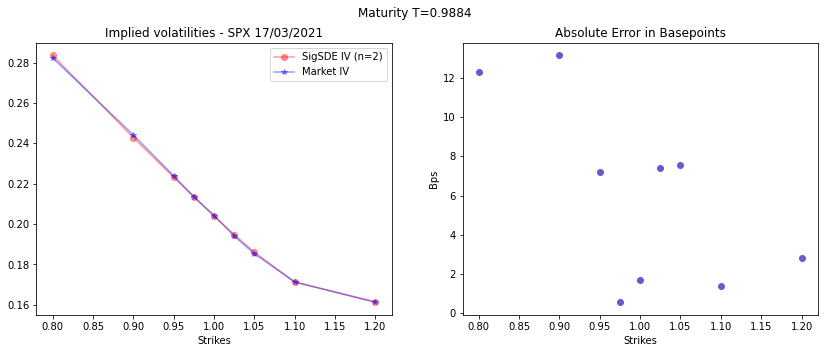

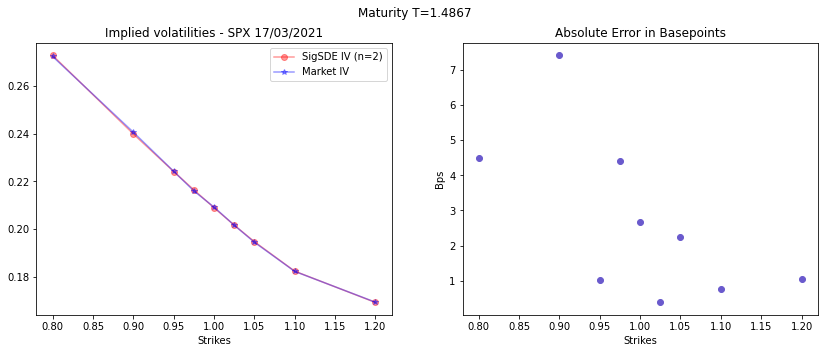

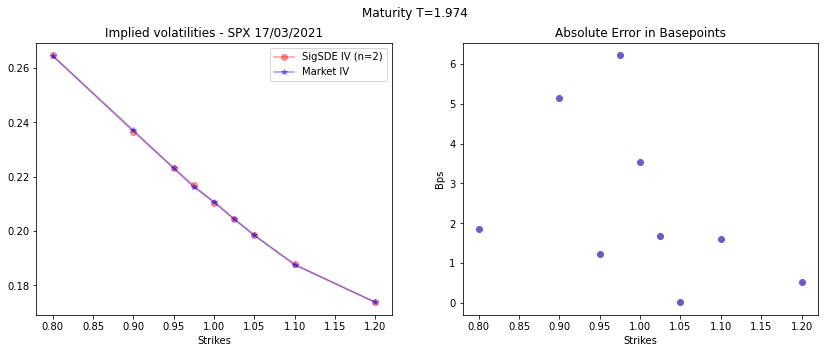

In [18]:
iv_mc=[]
%matplotlib inline
for j in range(len(maturities)):
    iv_calib_arr_mc_slice,sig_prices_mc_arr_slice=get_iv_from_calib(set_of_calibrated_prices[j],strikes,[maturities[j]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_calib_arr_mc_slice.squeeze(0),marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
    iv_mc.append(iv_calib_arr_mc_slice.squeeze(0))
    ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market IV')
    ax1.set_xlabel('Strikes')
    ax1.set_title('Implied volatilities - SPX 17/03/2021')
    ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice.squeeze(0)-iv_market[j])*10000,color='slateblue') 
    ax2.set_xlabel('Strikes')
    ax2.set_ylabel('Bps')
    ax2.set_title('Absolute Error in Basepoints')
    ax1.legend()
    #plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
    plt.show()


In [20]:
iv_market.shape

(7, 9)

In [23]:
iv_mc=np.array(iv_mc)

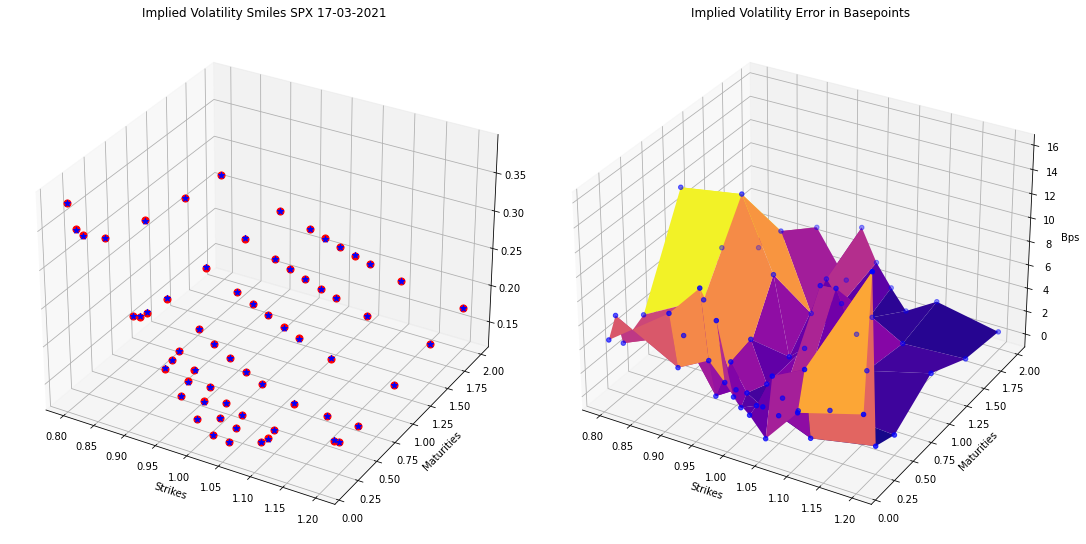

In [38]:

%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

#surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
#                       linewidth=0.5)

ax.scatter(strikes, YY, iv_mc,s=50,c='red',marker='o',depthshade=False)
ax.scatter(strikes, YY, iv_market,s=40,c='blue',marker='*',depthshade=False)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatility Smiles SPX 17-03-2021');
#ax.set_zlim(-1.01, 1.01)
#fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(strikes, YY, np.abs(np.array(iv_mc)-iv_market)*10000, rstride=1, cstride=1,
                cmap=cm.plasma,linewidth=0.5, edgecolor='none')

ax.scatter(strikes, YY, np.abs(np.array(iv_mc)-iv_market)*10000, s=20, c='blue')
#ax.plot_surface(strikes, YY, np.array(iv_mc), rstride=1, cstride=1,
#                cmap=cm.magma,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');
plt.savefig('IV_surface_SPX.png',dpi=300)
plt.tight_layout()
plt.show()

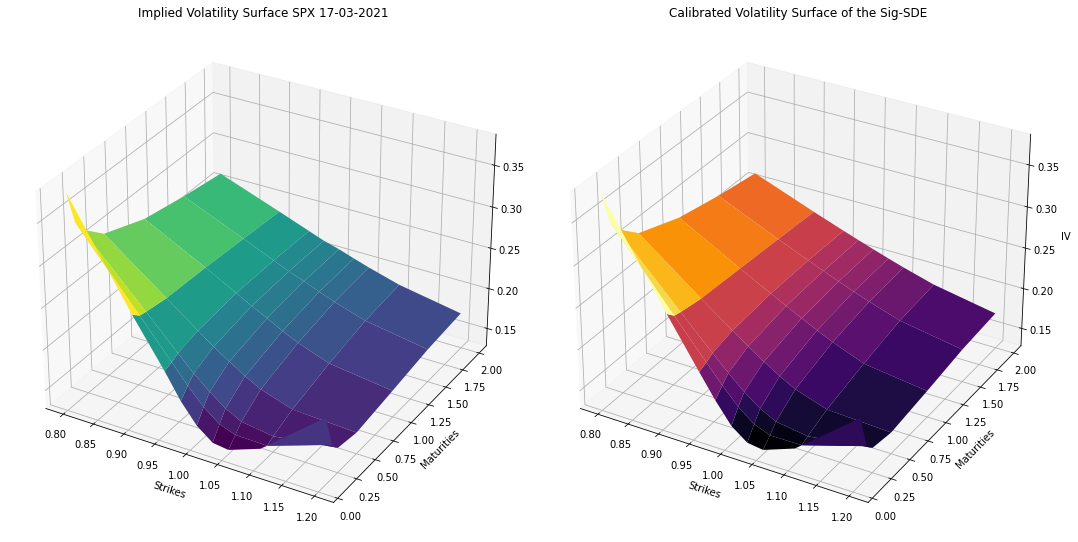

In [76]:

%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
                       linewidth=0.5)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surface SPX 17-03-2021');
#ax.set_zlim(-1.01, 1.01)
#fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes, YY, np.array(iv_mc), rstride=1, cstride=1,cmap=cm.inferno,
                       linewidth=0.5)
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Calibrated Volatility Surface of the Sig-SDE');
plt.savefig('IV_surface_comparison3.png',dpi=300)
plt.tight_layout()
plt.show()

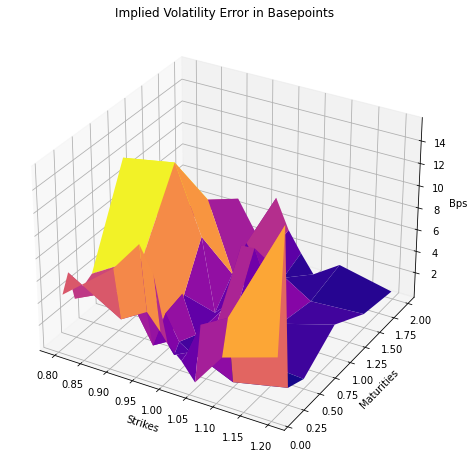

In [86]:
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(len(maturities))])

%matplotlib inline
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')


ax.plot_surface(strikes, YY, np.abs(np.array(iv_mc)-iv_market)*10000, rstride=1, cstride=1,
                cmap=cm.plasma,linewidth=0.5, edgecolor='none')
#ax.plot_surface(strikes, YY, np.array(iv_mc), rstride=1, cstride=1,
#                cmap=cm.magma,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');
plt.savefig('Surface_error_Basepoints3.png',dpi=500)

# <font color='cornflowerblue'> Sample from calibrated model </font>

In [261]:
def sample_calibrated_sigSDE(set_of_calibrated_params,n,maturities,new_tilde,keys_n,keys_n1,nbr_components,rho,y):
    idx_mat=len(maturities)-1
    time_and_bms=correlated_bms_correct(maturity_dict[maturities[idx_mat]],rho,maturities[idx_mat],0)
    augmented_bms=col_stack(time_and_bms)
    augmented_bms=torch.from_numpy(augmented_bms).unsqueeze(0)
    sig=signatory.signature(augmented_bms,n+1,stream=True,basepoint=True,scalar_term=True)
    sig_df=pd.DataFrame(sig.squeeze(0).numpy(), columns=keys_n1)
    tilde_sig_df=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys_n1,nbr_components,rho,y)
    nus=[tilde_sig_df-tilde_sig_df.iloc[maturity_dict[maturities[index]]-1,:] for index in range(0,idx_mat)]
    nus.insert(0,tilde_sig_df)
    list_of_adj=[np.dot(set_of_calibrated_params[j],nus[j].transpose()) for j in range(len(maturities))]
    
    first_step=list_of_adj[0][:maturity_dict[maturities[0]]]
    steps=[first_step]
    for k in range(1,len(maturities)):
        aux=np.array([list_of_adj[j][:maturity_dict[maturities[k]]] for j in range(0,k+1)])
        aux2=np.sum(aux,axis=0)
        aux2=aux2[maturity_dict[maturities[k-1]]:maturity_dict[maturities[k]]]
        steps.append(aux2)
    traj=np.concatenate(steps)+initial_price
    return traj

In [271]:
list_samples=np.array([sample_calibrated_sigSDE(set_of_calibrated_params,n,maturities,new_tilde,keys_n,keys_n1,nbr_components,rho,y) for k in range(100000)])

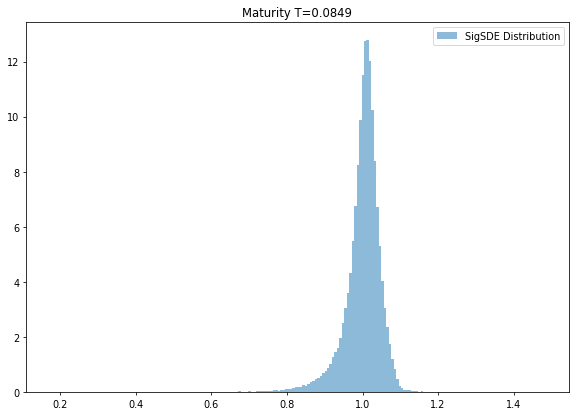

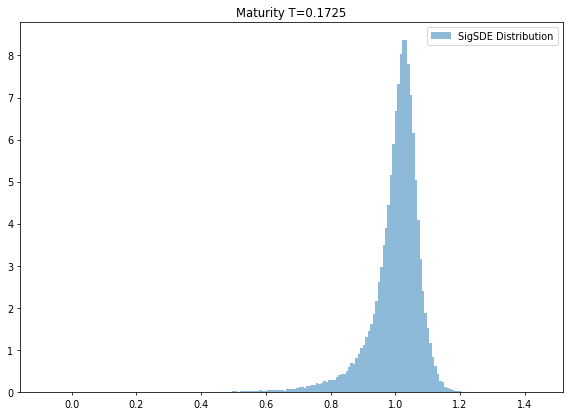

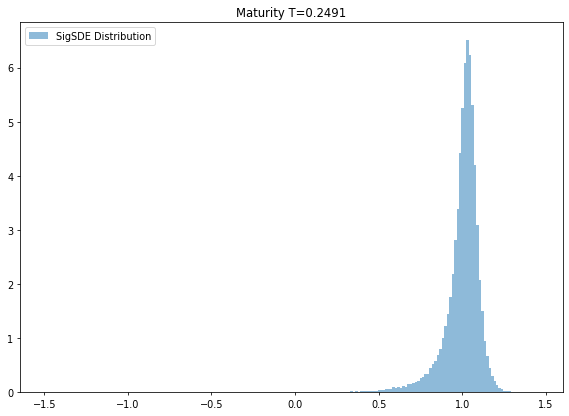

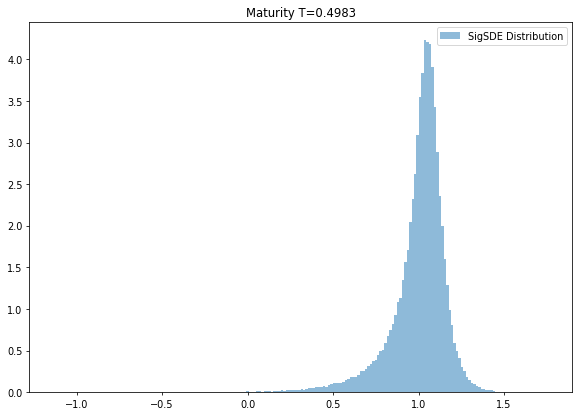

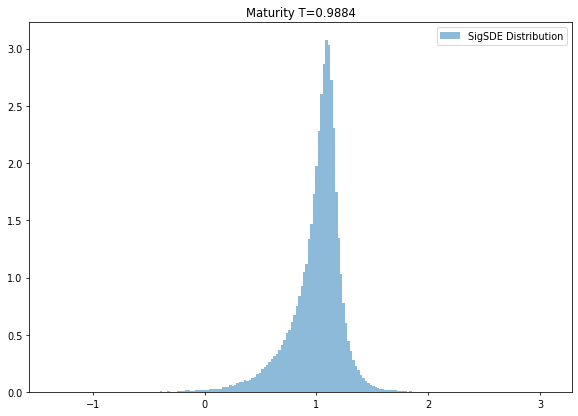

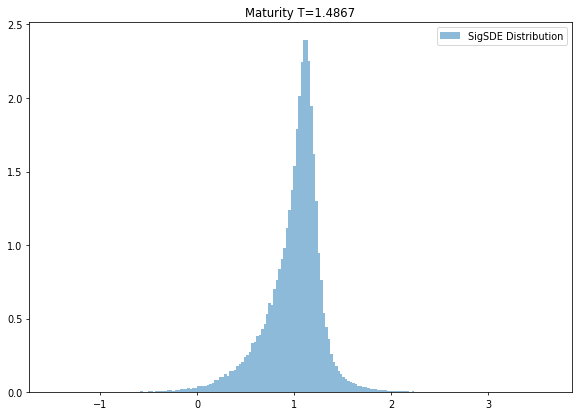

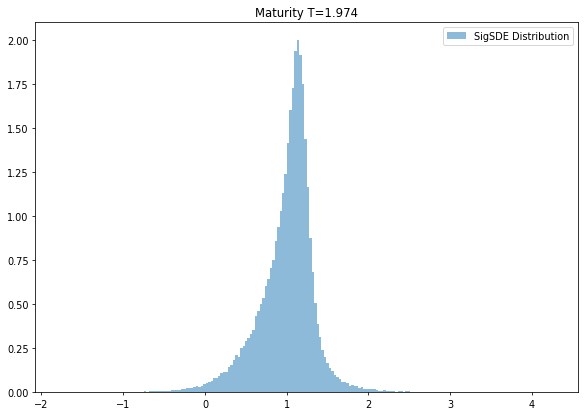

In [272]:
for mat in maturities:
    plt.figure(figsize=(10, 7), dpi=70)
    plt.hist(list_samples[:,maturity_dict[mat]-1],bins=200,alpha=0.5, label='SigSDE Distribution',density=True)
    #plt.vlines(initial_price,0,0.07)
    plt.legend()
    plt.title('Maturity T={}'.format(round(mat,4)))
    plt.show()

In [273]:
np.mean(np.maximum(list_samples[:,maturity_dict[maturities[0]]-1]-strikes[0][0],0))

0.20069988345130235

In [274]:
Premium[0]

0.20082604199103854

# <font color='cornflowerblue'> Different days of the SPX option </font>

In [27]:
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.embed import file_html
import chart_studio.plotly as py
import os
output_notebook()

Loading BokehJS ...

In [28]:
prices_history=np.load('prices_history_SPX.npy')
history=np.load('history_SPX.npy')
ivs_history=np.load('iv_surf_history_SPX.npy')

In [29]:
colours_palette=['royalblue','darkorange','seagreen','firebrick','mediumpurple','peru','deeppink']
for t in range(len(maturities)):
    figure2 = figure(width=500, height=400,title='Implied Volatilities SPX - T={}'.format(round(maturities[t],4)))
    for j in range(len(history)):
        figure2.line(strikes[j], ivs_history[j][t], legend_label=history[j],color=colours_palette[j])
        figure2.circle(strikes[j], ivs_history[j][t],fill_color=colours_palette[j], size=7,alpha=0.5)
        figure2.xaxis.axis_label = 'Strike'  
        figure2.yaxis.axis_label = 'IV'
        #figure2.legend.glyph_height=2
        figure2.legend.glyph_width=9
        #legend = Legend(glyph_height=30,glyph_width=30)
        figure2.legend.label_text_font_size = '8pt'
    show(figure2)

In [30]:
x_=np.load(os.path.join('prova','calibrated_prices_MC_history(1000000,1,[0],2,0).npy'))
iv_calib1,sig_prices_mc_arr1=get_iv_from_calib(x_,strikes,[maturities[0]])

# <font color='cornflowerblue'> Get fits for the whole history with $n=2$ </font>

In [32]:
n=2
set_calib_p=[]
set_calib_param=[]
for k in range(len(history)):
    for j in range(len(maturities)):
        set_calib_p.append(np.load(os.path.join('prova',f'calibrated_prices_MC_history(1000000,1,[{j}],{n},{k}).npy')))
        set_calib_param.append(np.load(os.path.join('prova',f'ell_MC_history({2},2,-0.5,1000000,1,[{j}],{k}).npy')))
set_calib_p=np.array(np.split(np.array(set_calib_p),len(history),axis=0)) 
set_calib_param=np.array(np.split(np.array(set_calib_param),len(history),axis=0))  

In [33]:
iv_calib_history=[]
%matplotlib inline
for k in range(len(history)):
    for j in range(len(maturities)):
        iv_calib_slice,sig_prices_mc_arr_slice=get_iv_from_calib(set_calib_p[k,j,:],strikes,[maturities[j]])
        iv_calib_history.append(iv_calib_slice.squeeze(0))
iv_calib_history=np.array(iv_calib_history)
iv_calib_history=np.array(np.split(iv_calib_history,len(history),axis=0))  

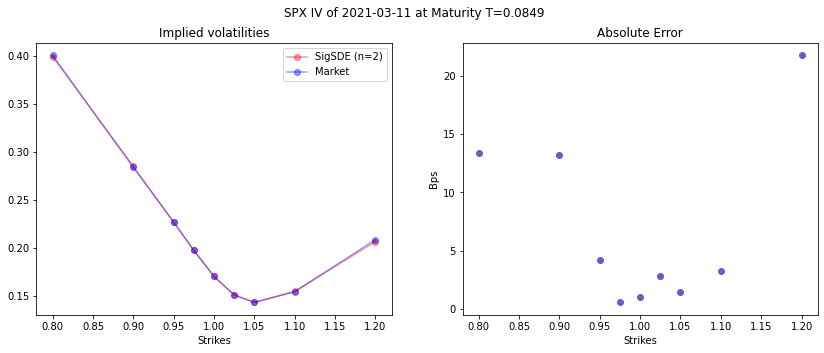

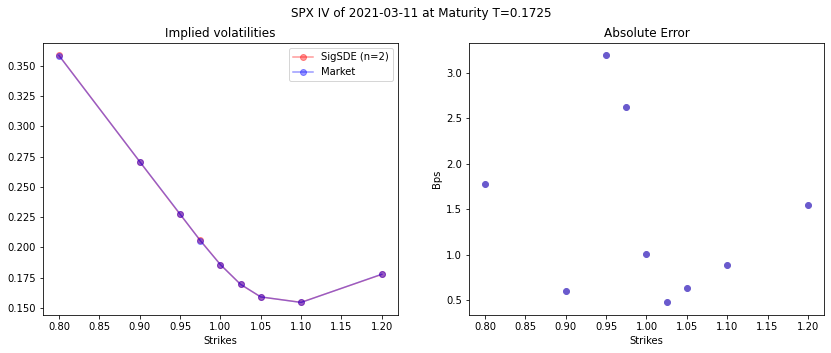

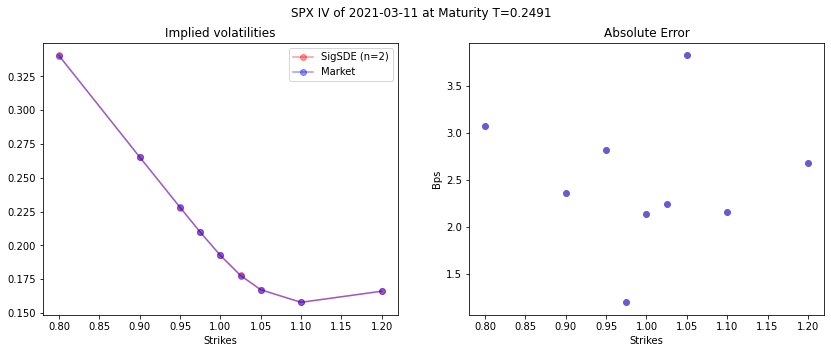

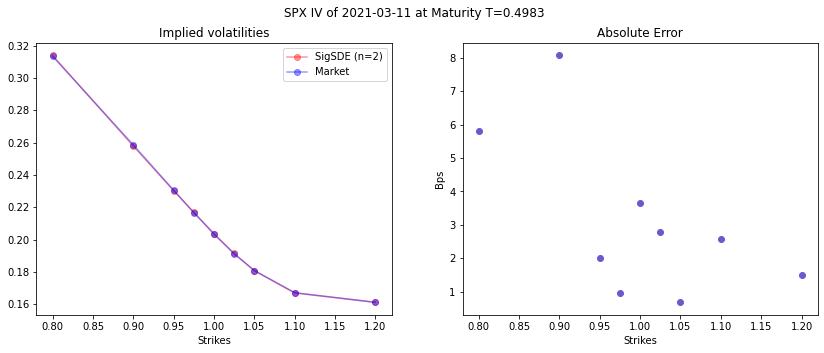

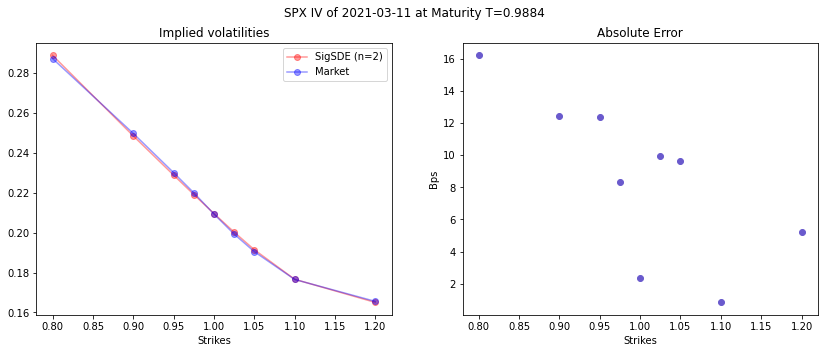

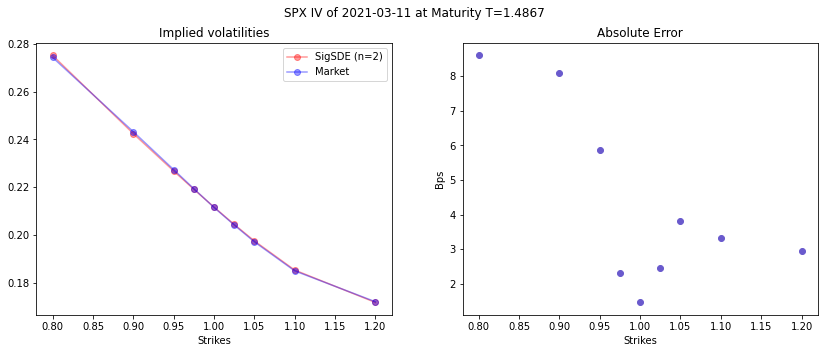

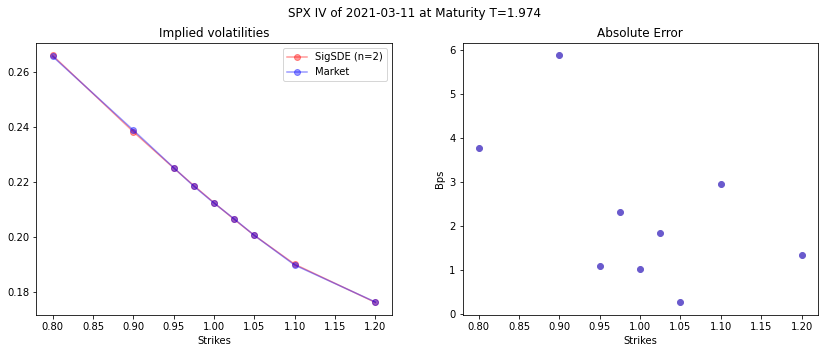

----------------------------------


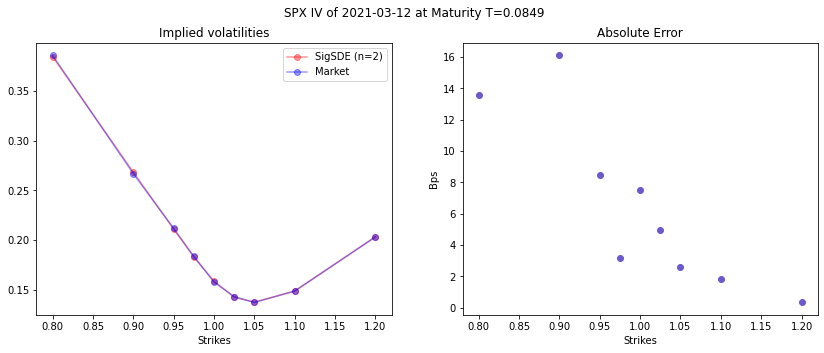

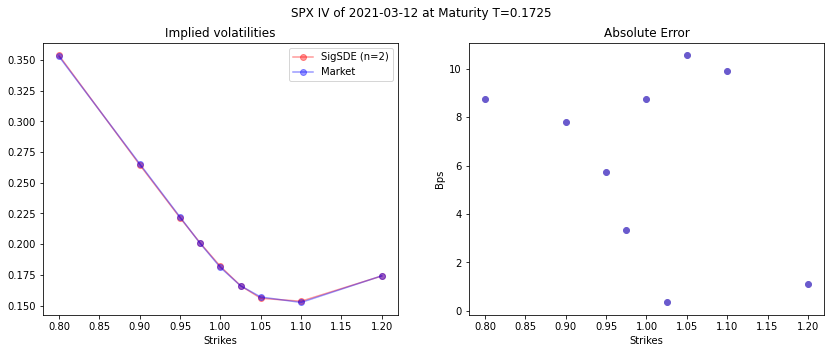

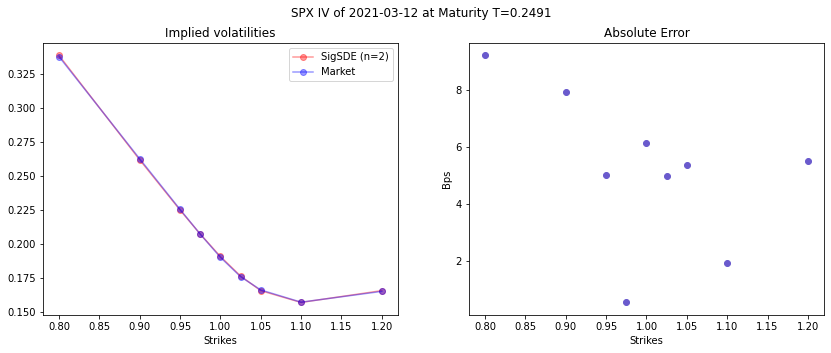

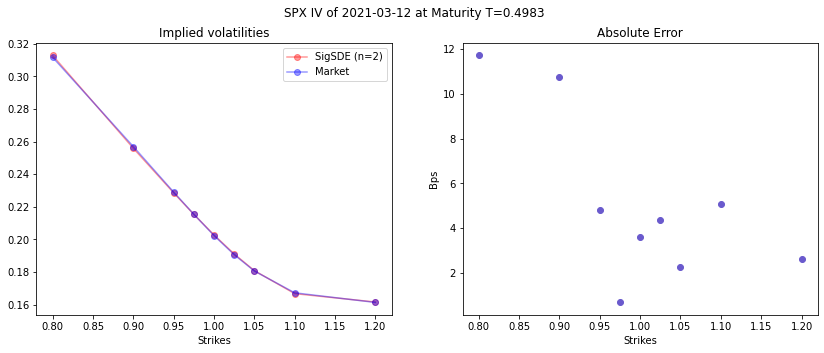

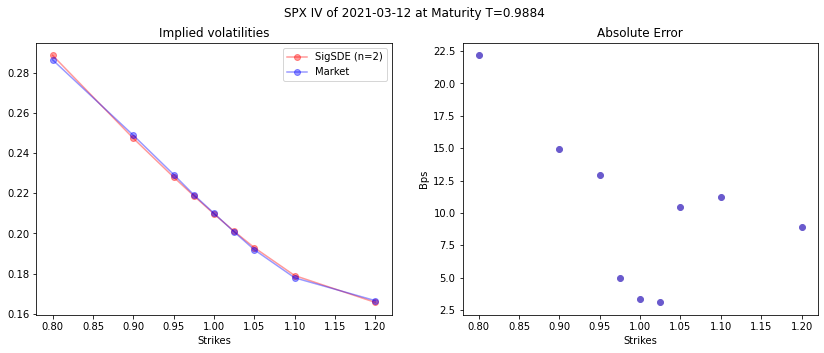

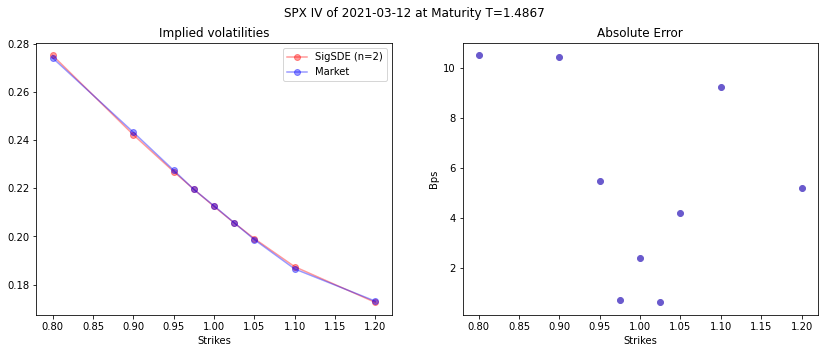

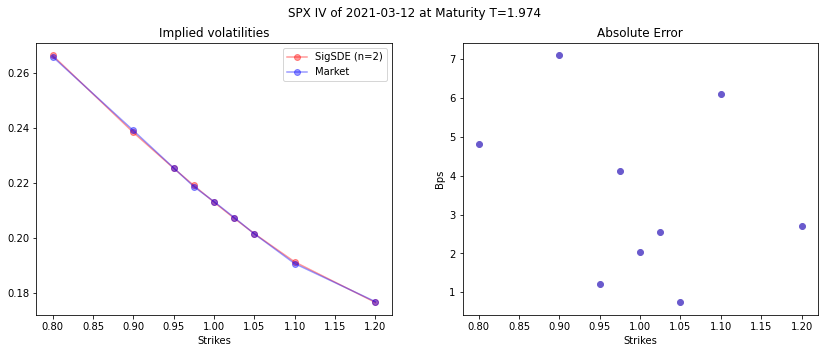

----------------------------------


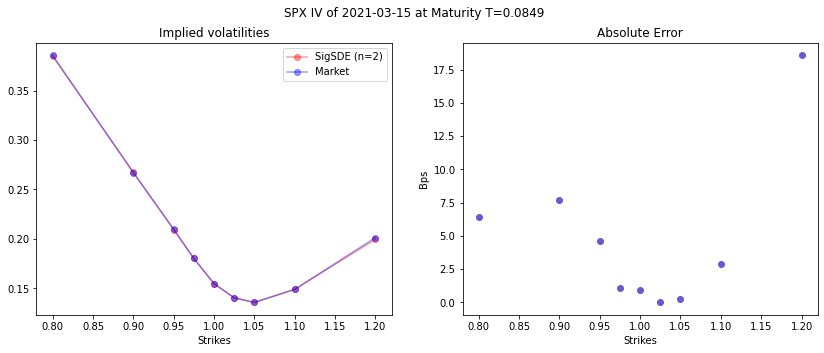

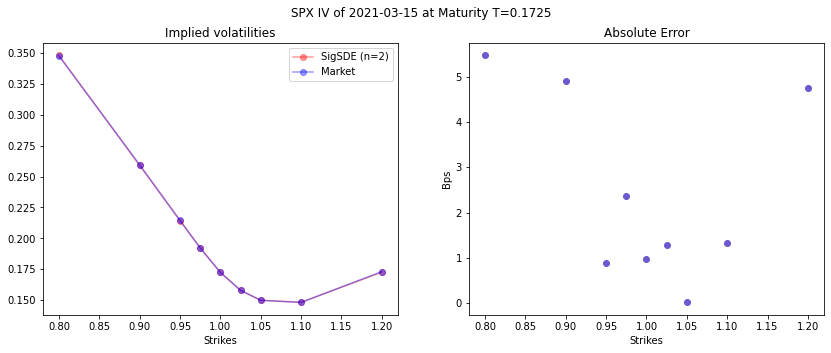

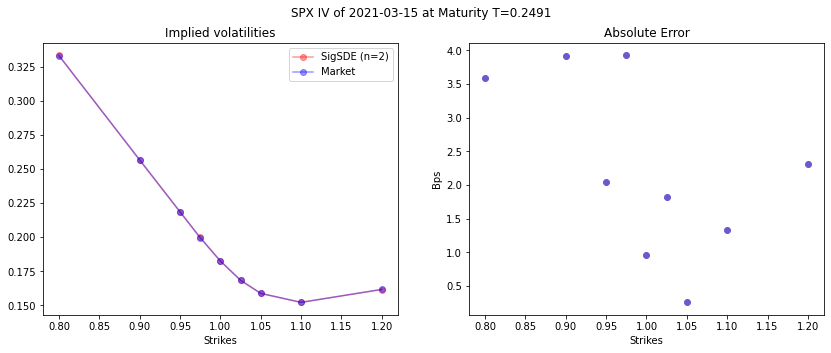

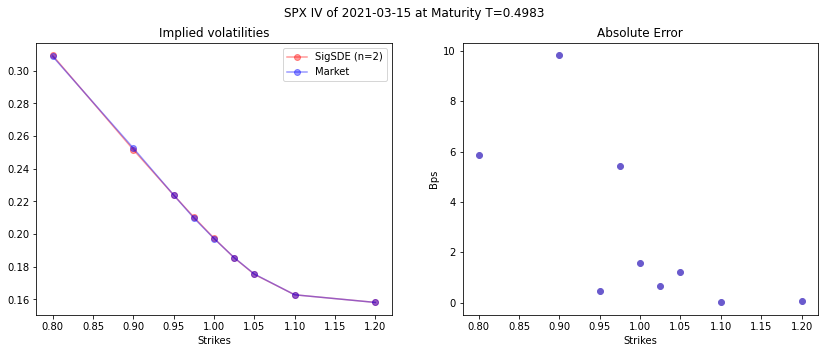

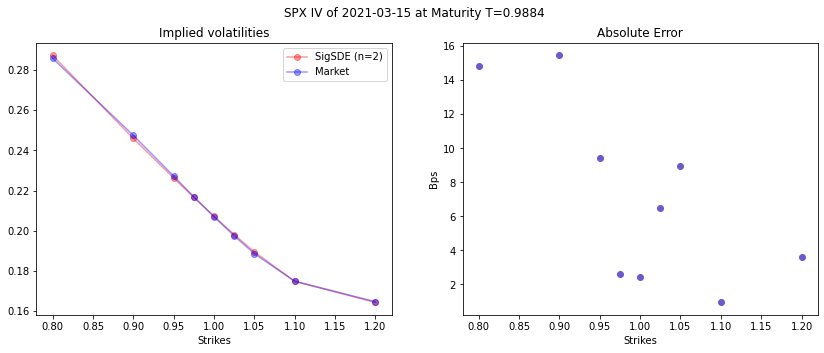

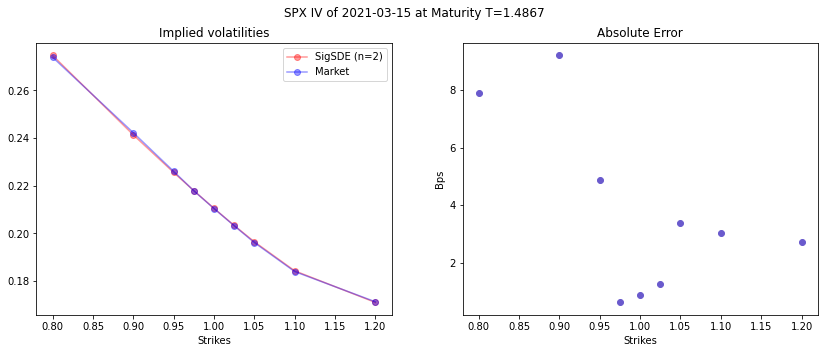

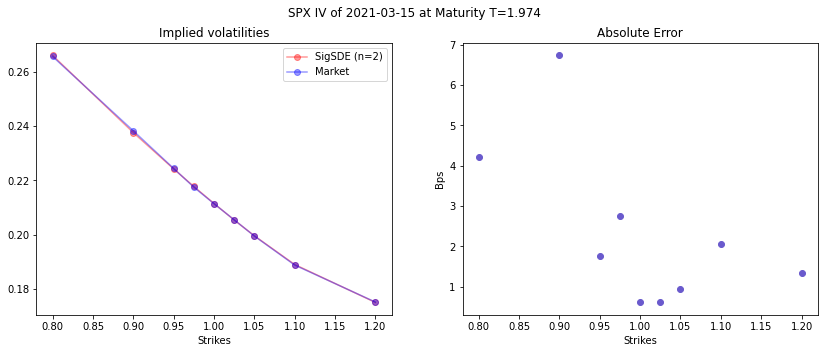

----------------------------------


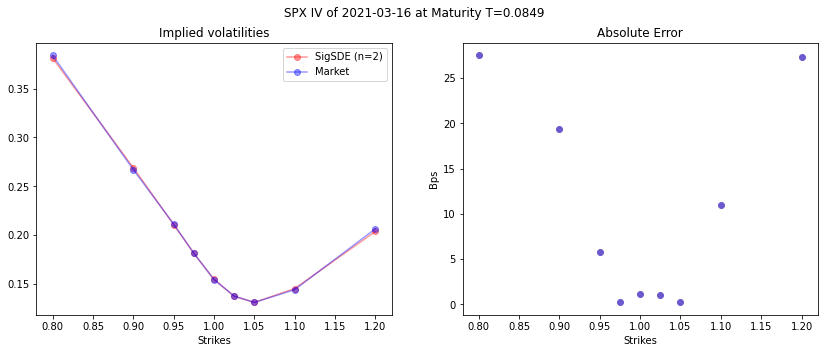

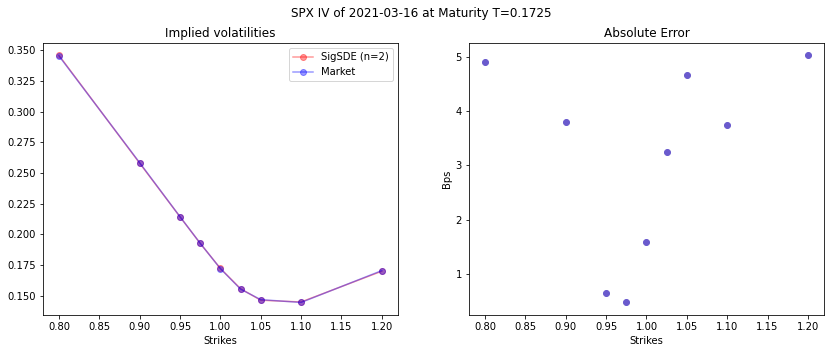

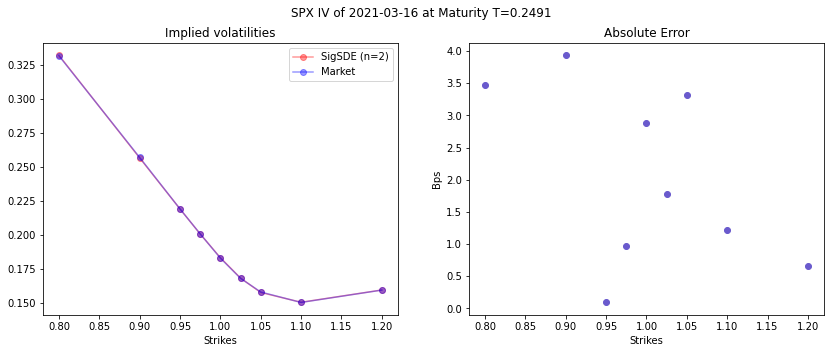

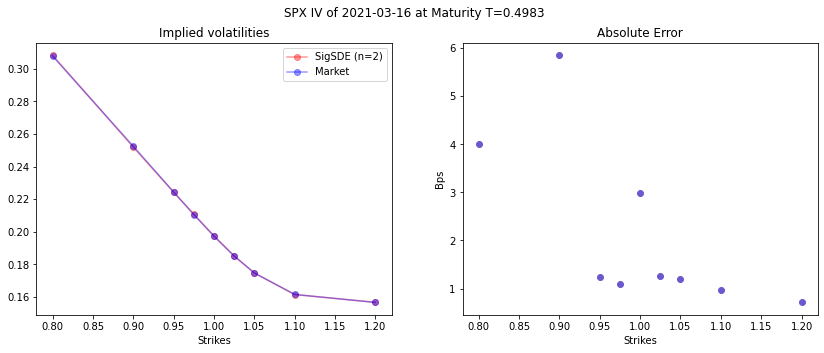

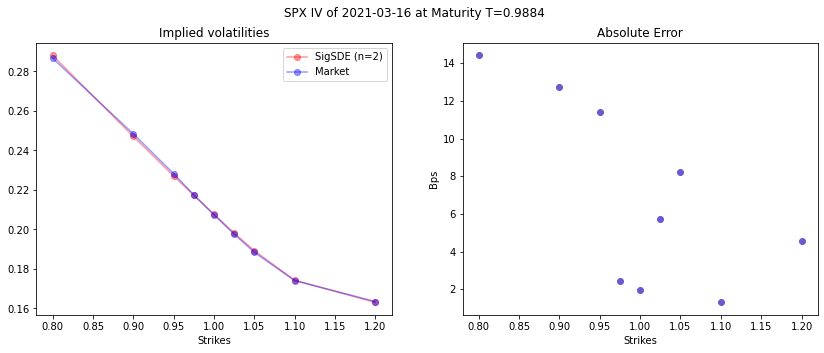

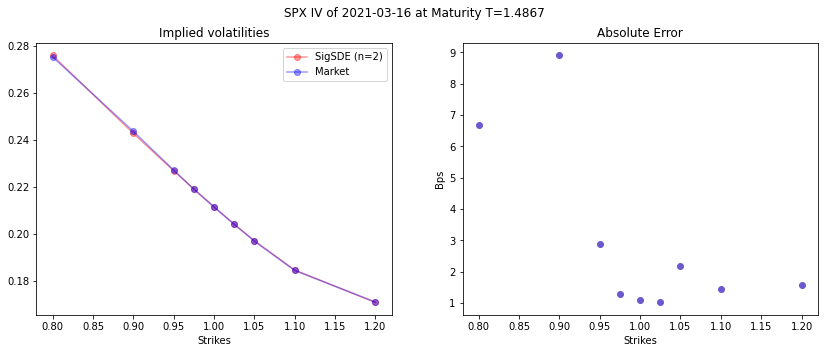

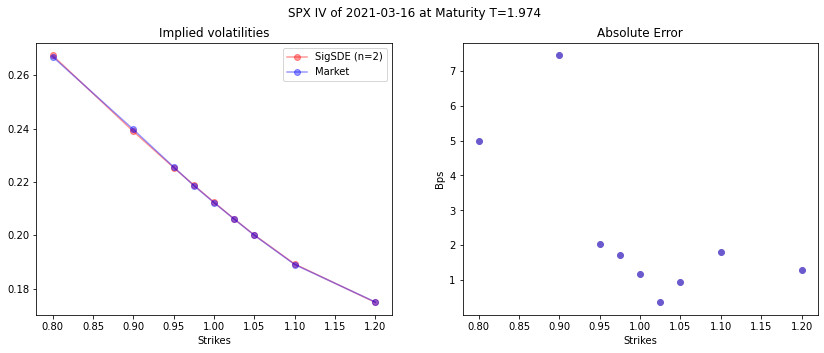

----------------------------------


In [34]:
for t in range(2,len(history)-1):
    for j in range(len(maturities)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
        fig.suptitle('SPX IV of '+history[t]+' at Maturity T={}'.format(round(maturities[j],4)))
        ax1.plot(strikes[0],iv_calib_history[t,j,:],marker='o',color='r',alpha=0.4,label=f'SigSDE (n=2)')
        ax1.plot(strikes[0],ivs_history[t,j,:],marker='o',color='b',alpha=0.4,label=f'Market')
        ax1.set_xlabel('Strikes')
        ax1.set_title('Implied volatilities')
        ax2.scatter(strikes[0],np.abs(iv_calib_history[t,j,:]-ivs_history[t,j,:])*10000,color='slateblue')
        ax2.set_xlabel('Strikes')
        ax2.set_ylabel('Bps')
        ax2.set_title('Absolute Error')
        ax1.legend()
        plt.show()
    print('----------------------------------')

### <font color='cornflowerblue'> Check of the parameters </font>

In [866]:
idx_history=[2,3,4,5]

In [867]:
n=2
chiavi=np.array([esig.sigkeys(3,n).strip('').split()[k]+str('~B') for k in range(set_of_calibrated_params.shape[1])])

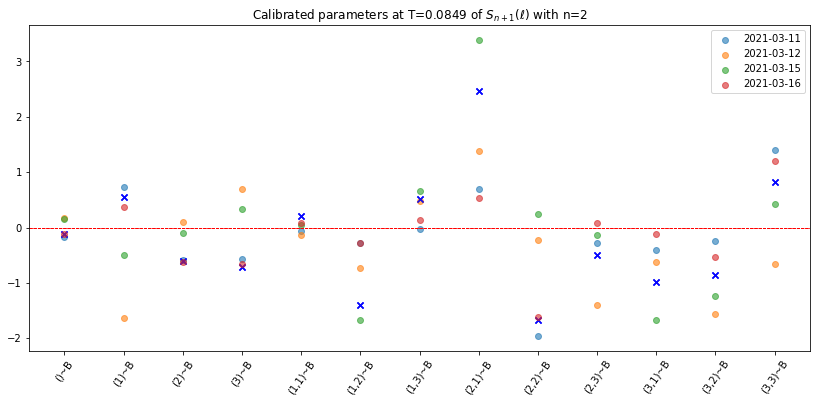

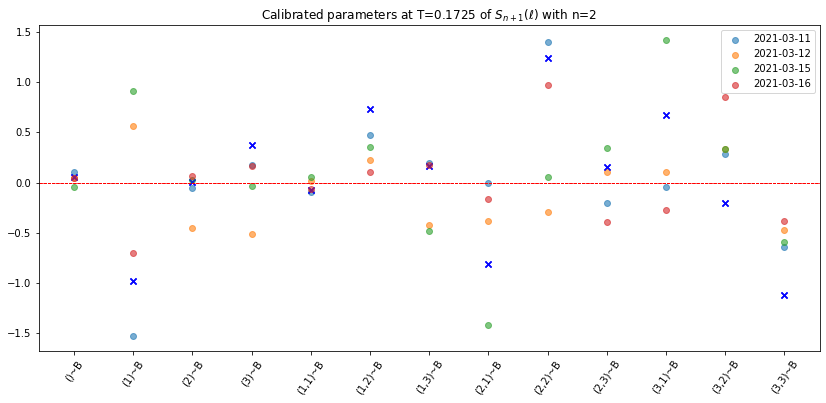

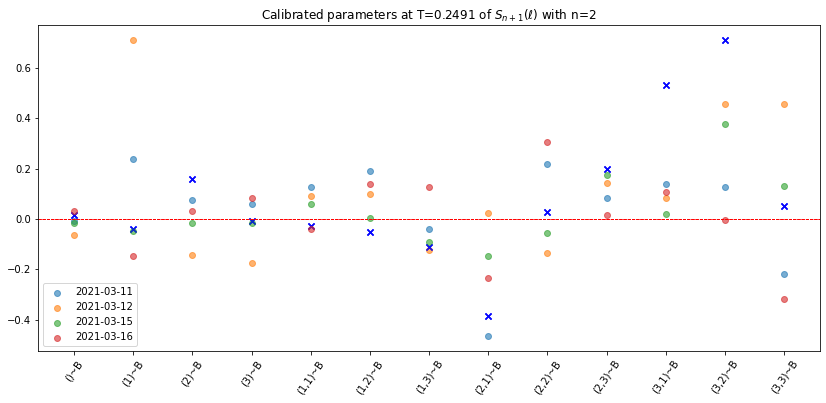

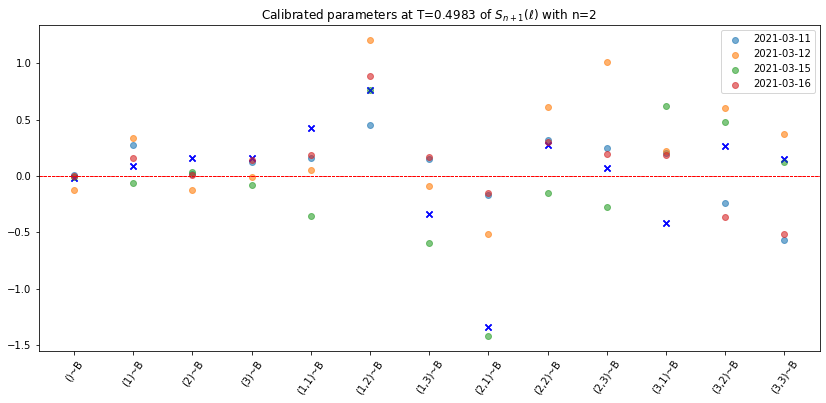

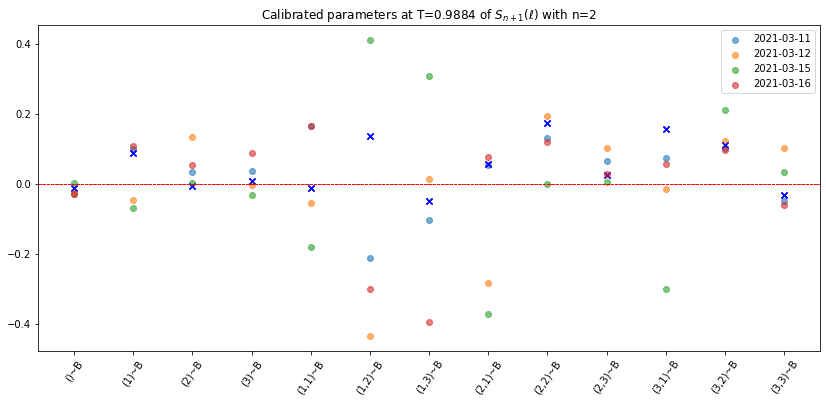

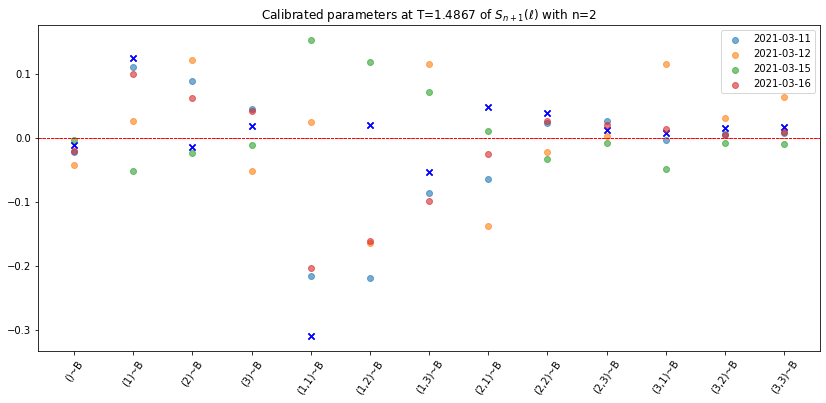

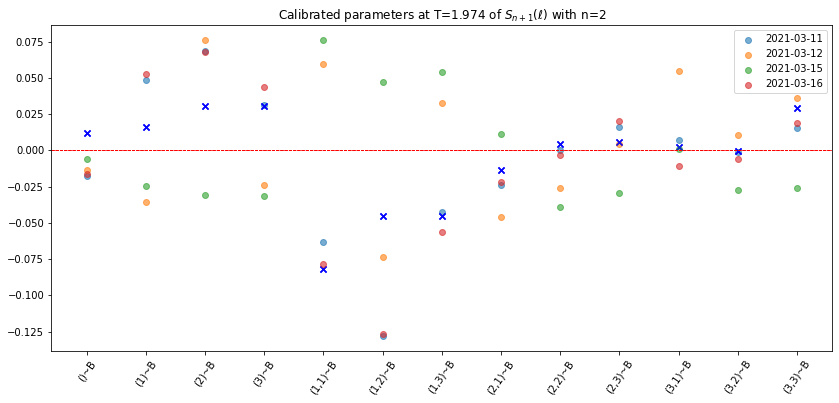

In [877]:
%matplotlib inline
for j in range(len(maturities)):
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    for t in idx_history:
        ax.axhline(y=0,color='r', linestyle='--',linewidth=0.8)
        ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='x',alpha=0.6,color='blue')
        ax.scatter(chiavi,set_calib_param[t,j,:],label=history[t],marker='o',alpha=0.6)
        plt.setp(ax.get_xticklabels(), rotation=55)
        ax.set_title(r'Calibrated parameters at T={}'.format(round(maturities[j],4))+' of $S_{n+1}(\ell)$ with'+' n={}'.format(n)) #
    ax.legend()
   # plt.savefig('Parameters_TV_all_mat.png',dpi=800)
    plt.show()

# <font color='cornflowerblue'> Get fits for the whole history with $n=3$ </font>

In [49]:
n=3
set_calib_p=[]
set_calib_param=[]
for k in range(len(history)):
    for j in range(len(maturities)):
        set_calib_p.append(np.load(os.path.join('prova',f'calibrated_prices_MC_history(1000000,1,[{j}],{n},{k}).npy')))
        set_calib_param.append(np.load(os.path.join('prova',f'ell_MC_history({n},2,-0.5,1000000,1,[{j}],{k}).npy')))
set_calib_p=np.array(np.split(np.array(set_calib_p),len(maturities),axis=0)) 
set_calib_param=np.array(np.split(np.array(set_calib_param),len(history),axis=0))  

In [54]:
set_calib_param.shape

(7, 7, 40)

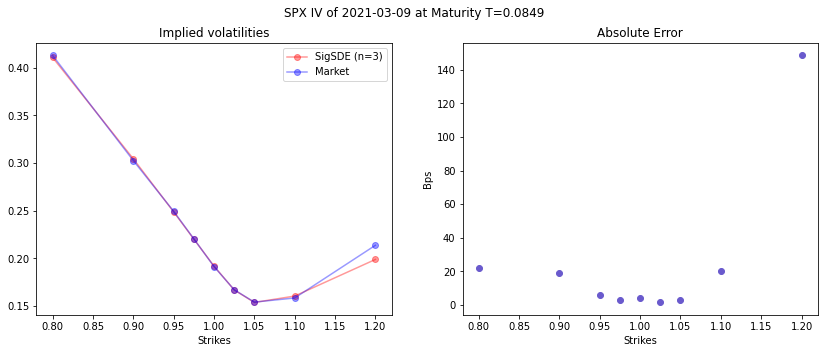

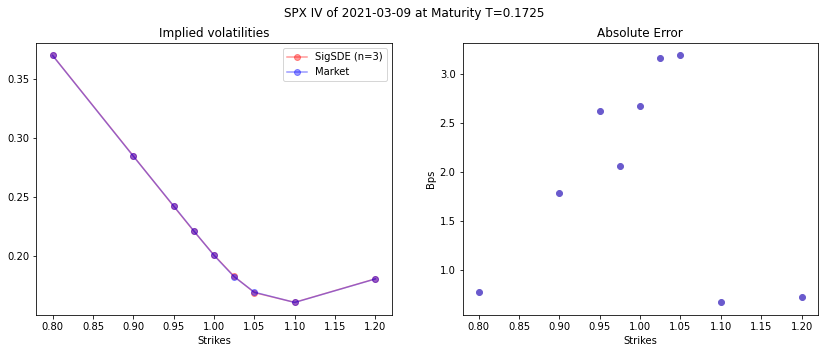

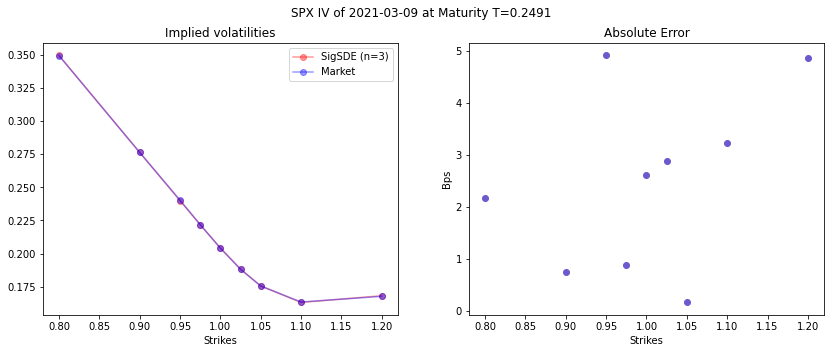

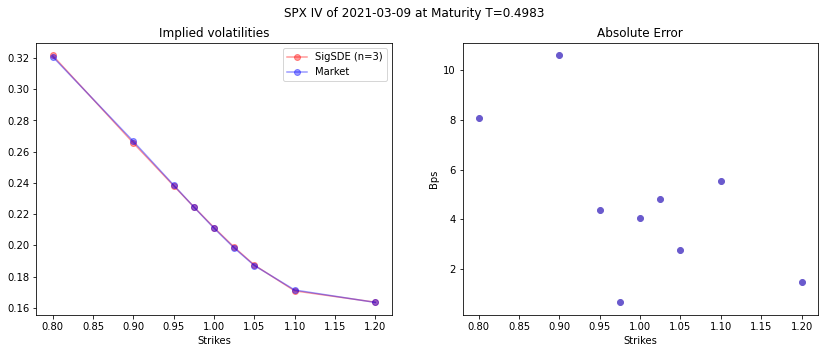

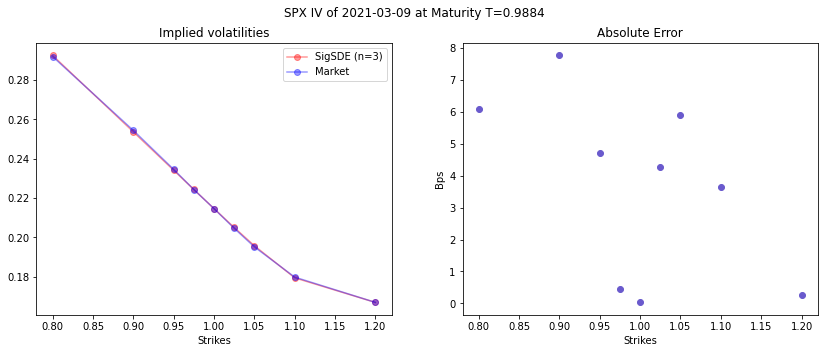

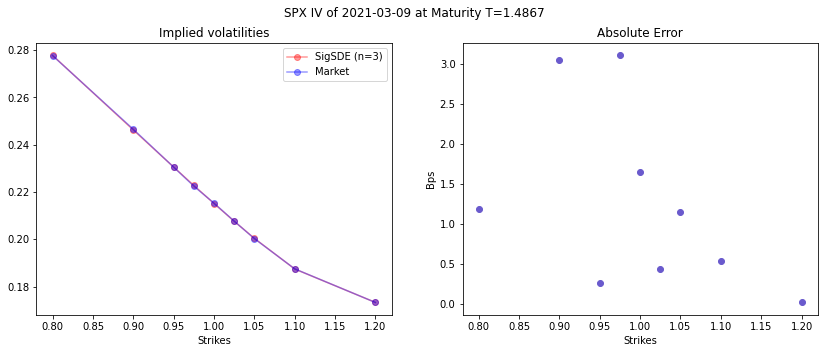

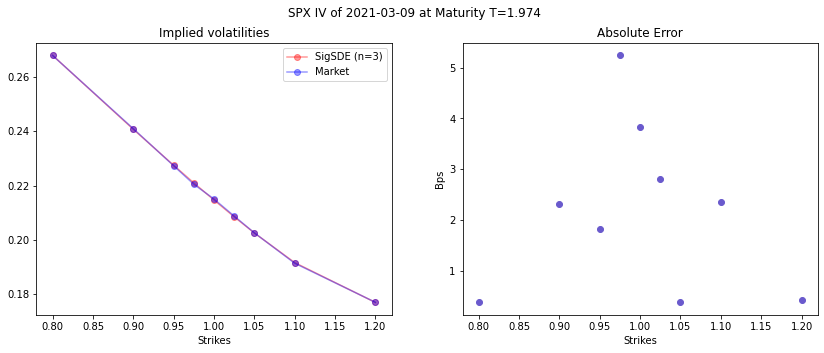

----------------------------------


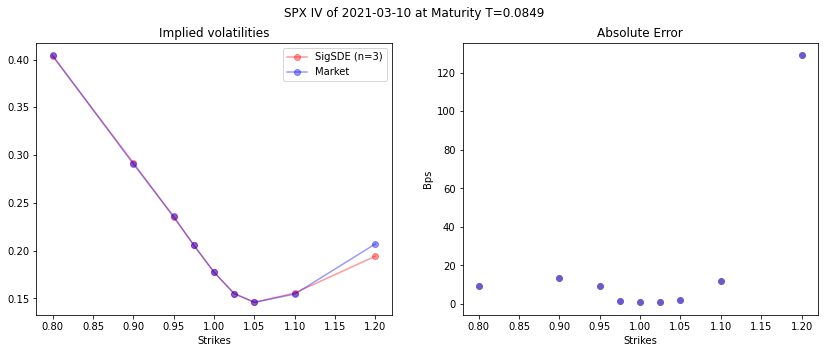

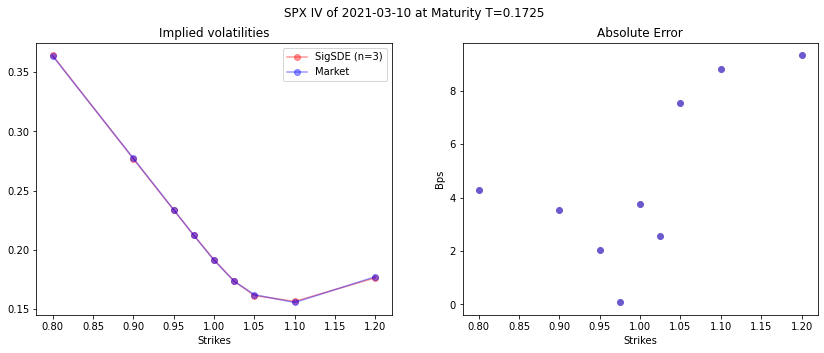

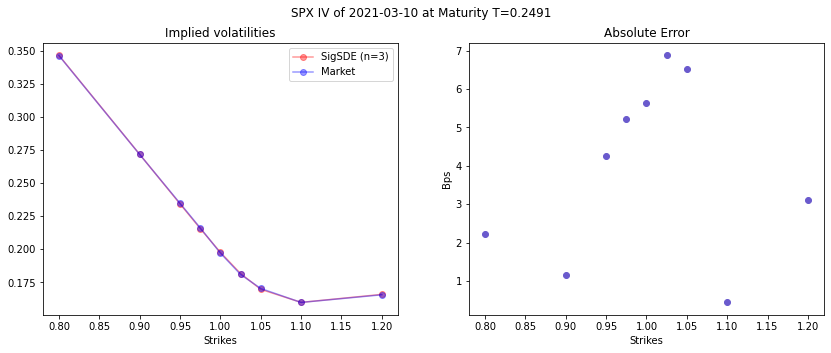

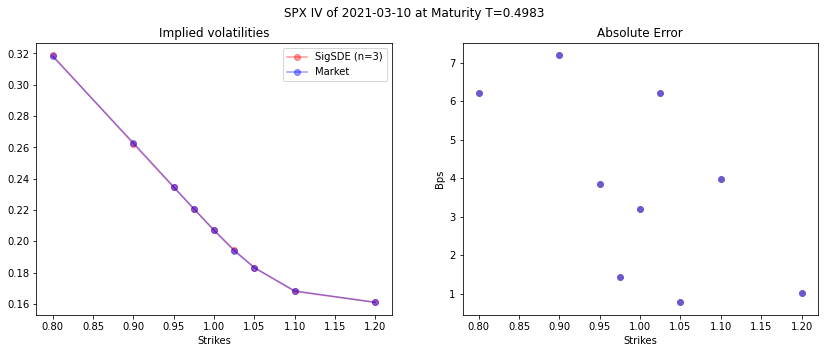

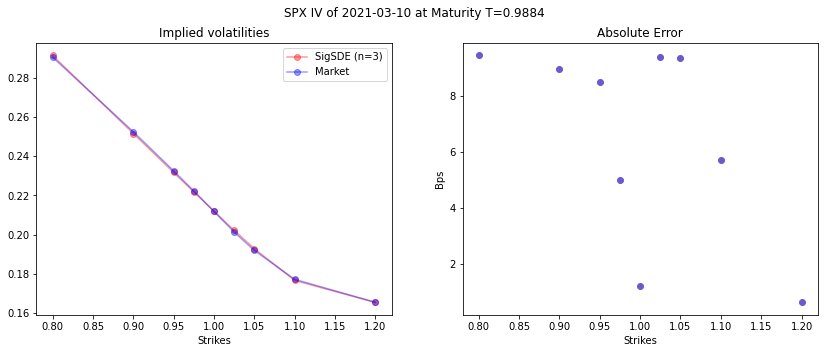

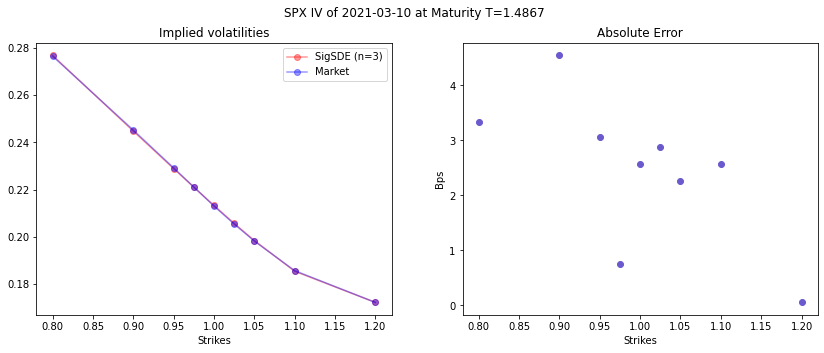

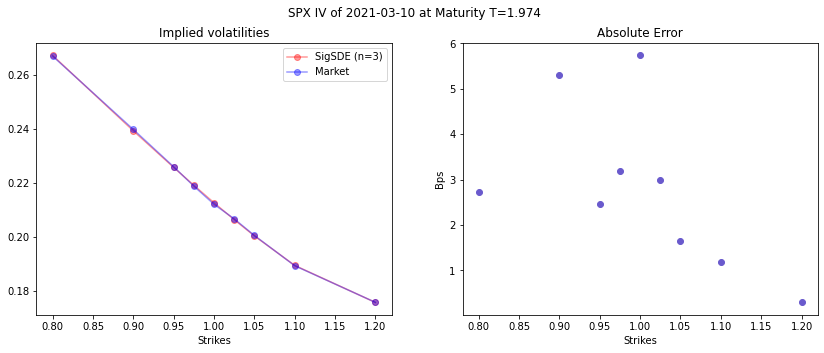

----------------------------------


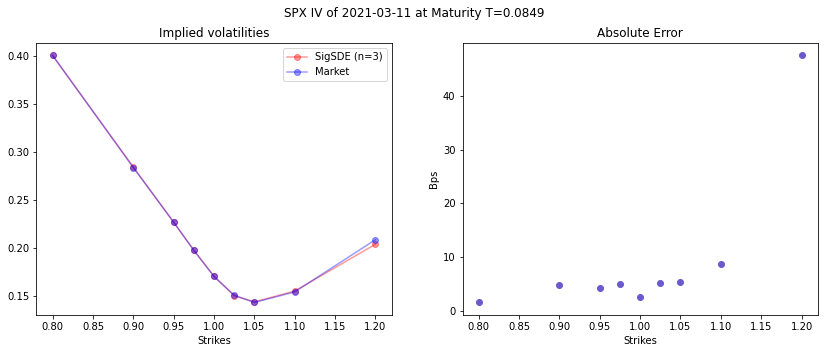

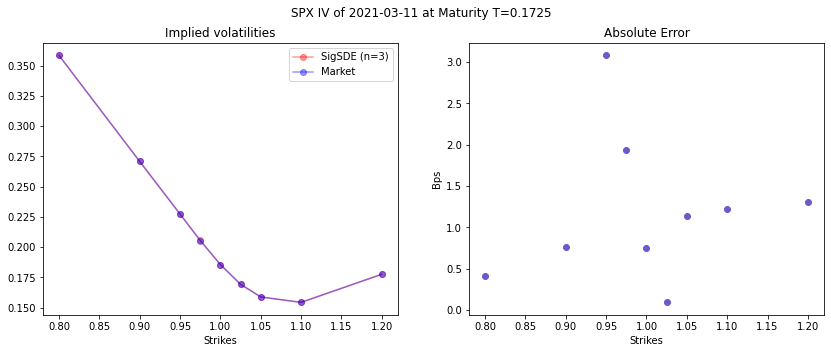

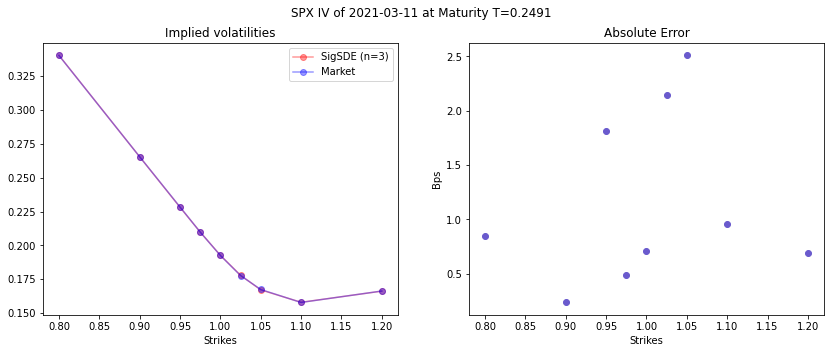

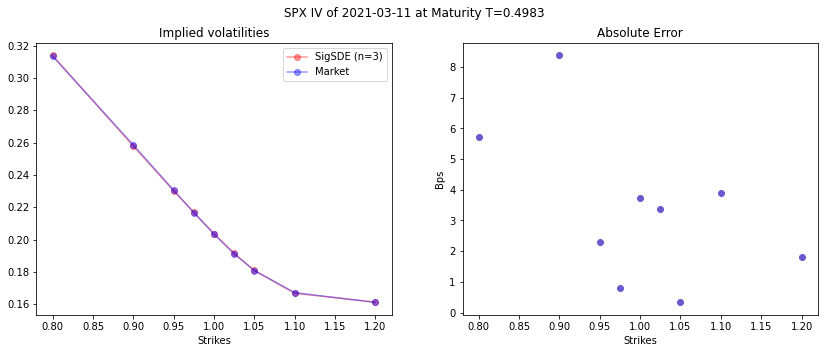

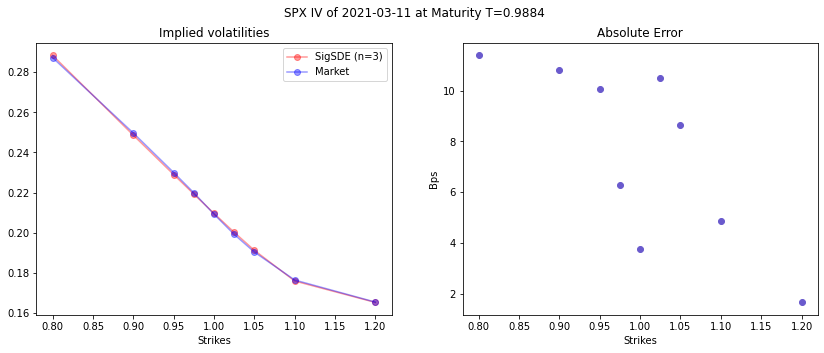

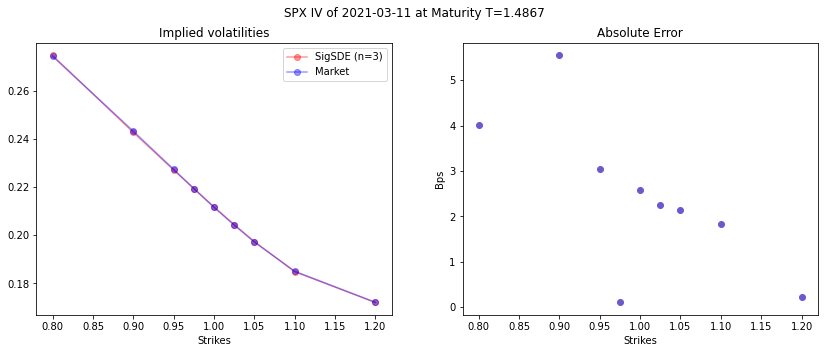

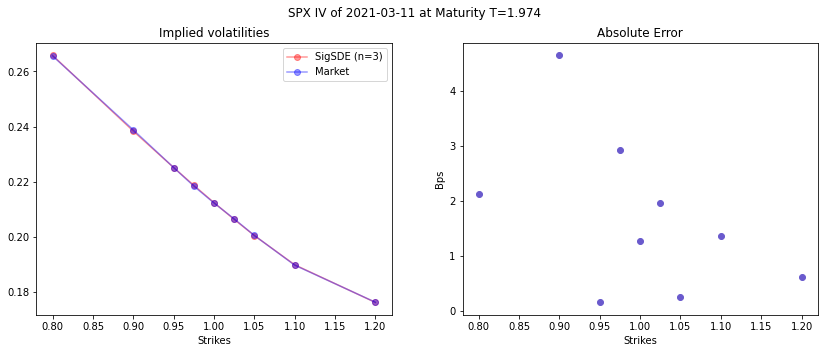

----------------------------------


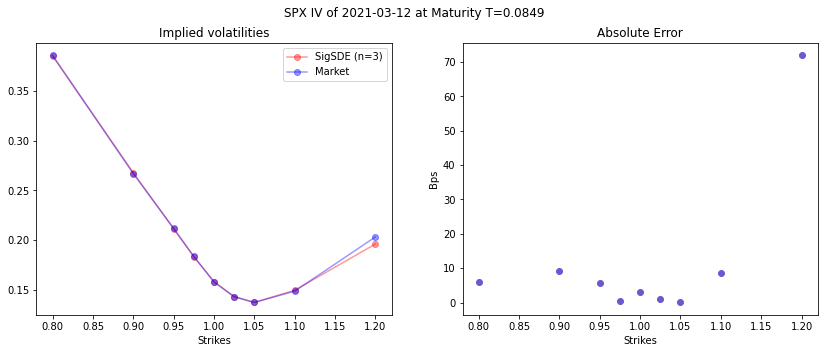

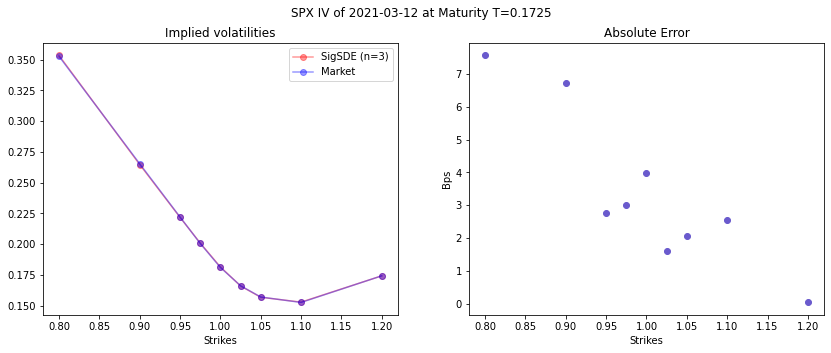

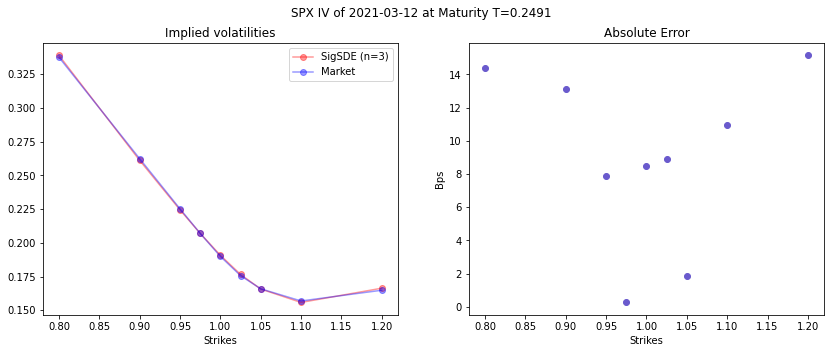

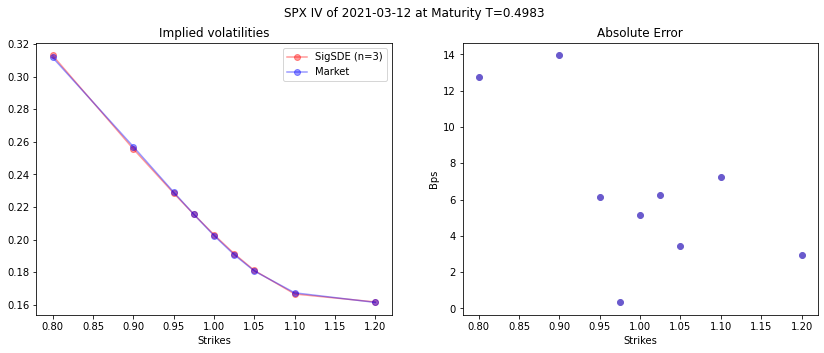

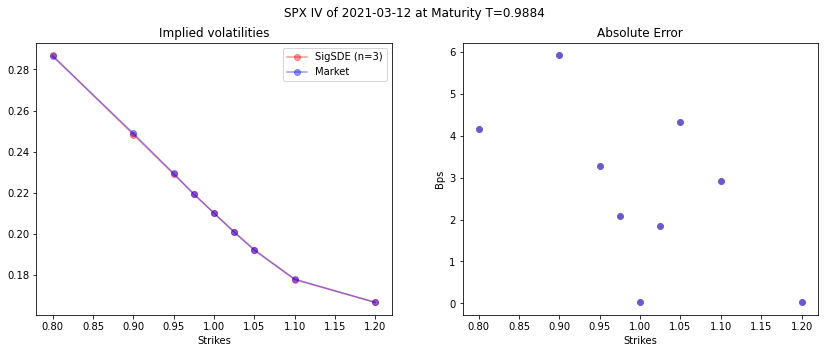

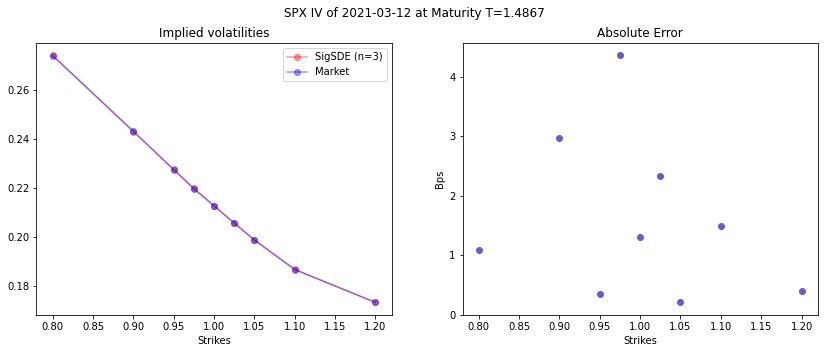

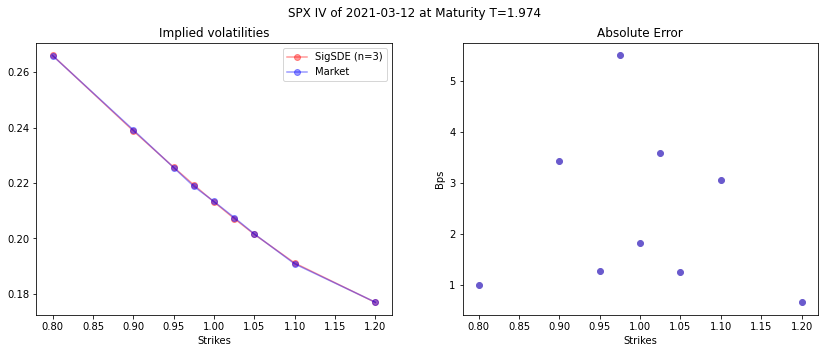

----------------------------------


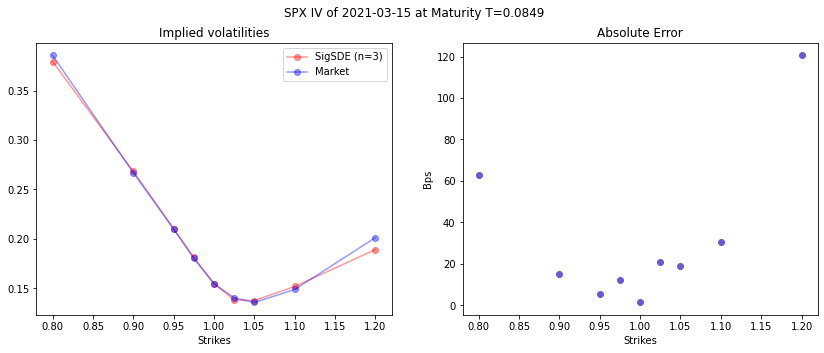

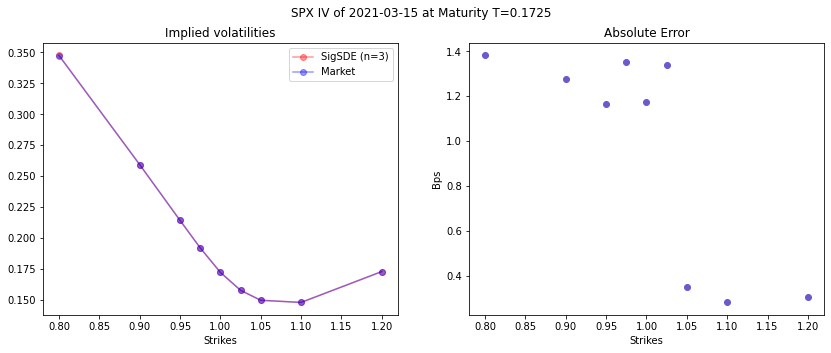

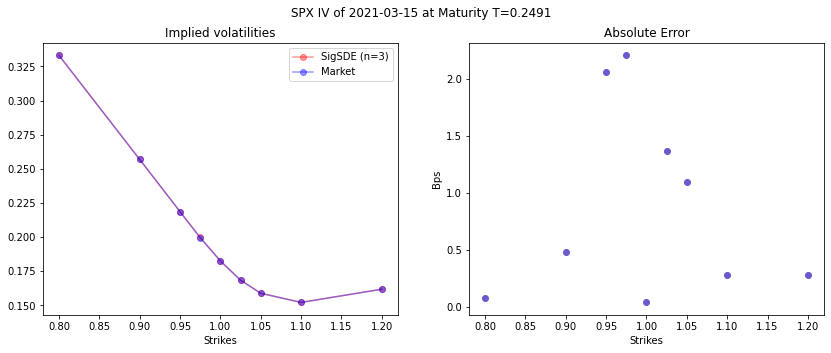

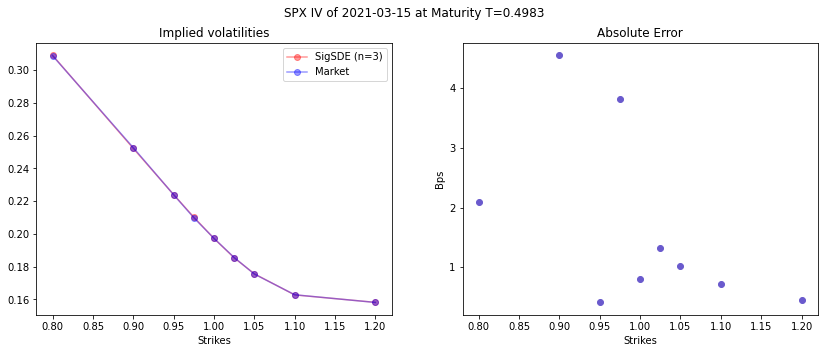

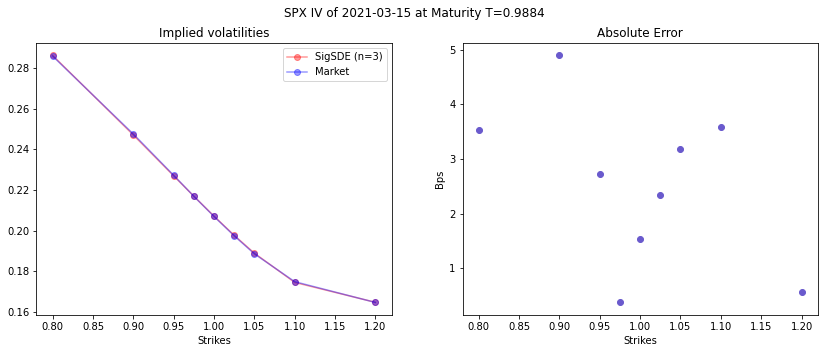

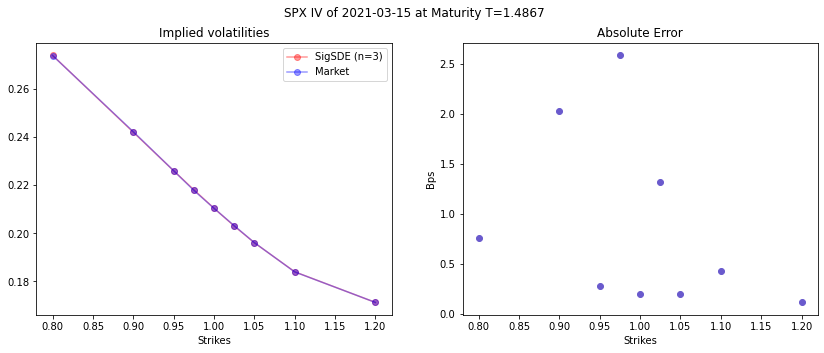

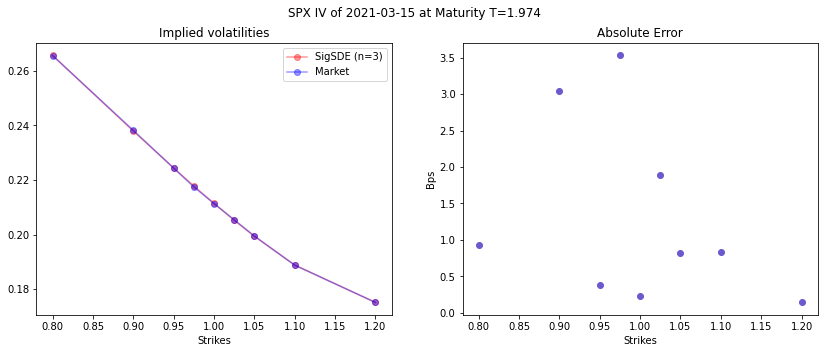

----------------------------------


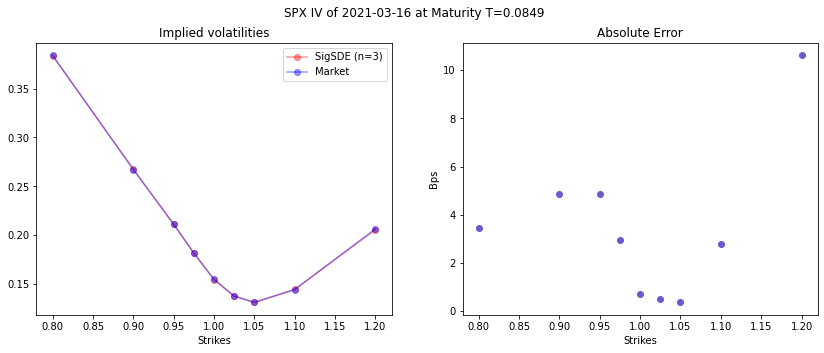

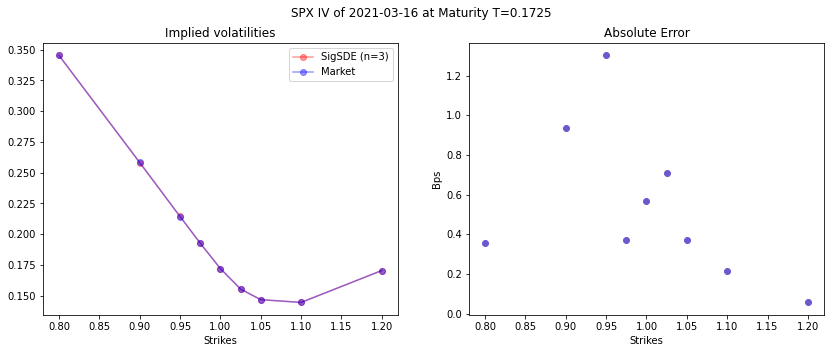

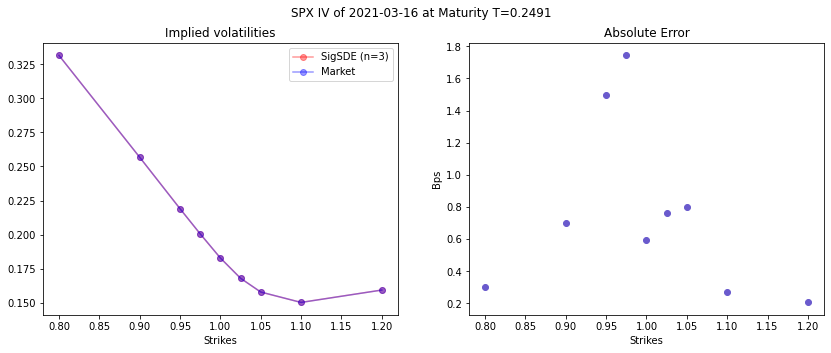

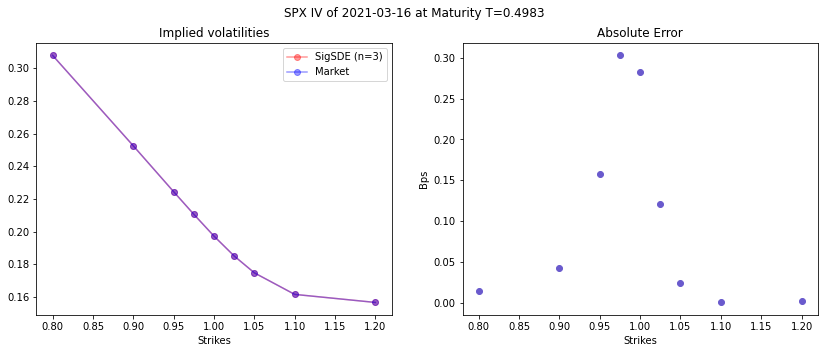

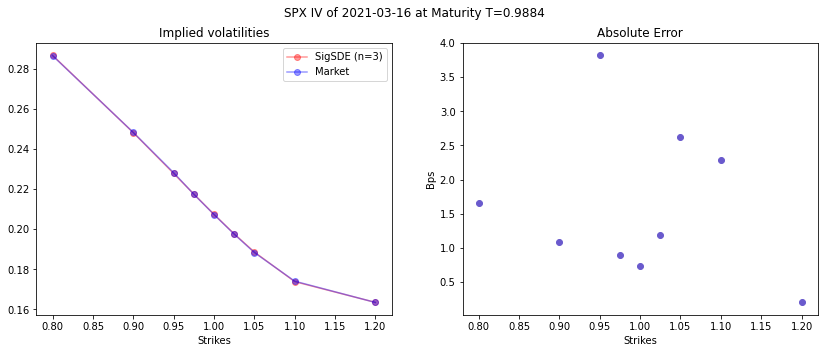

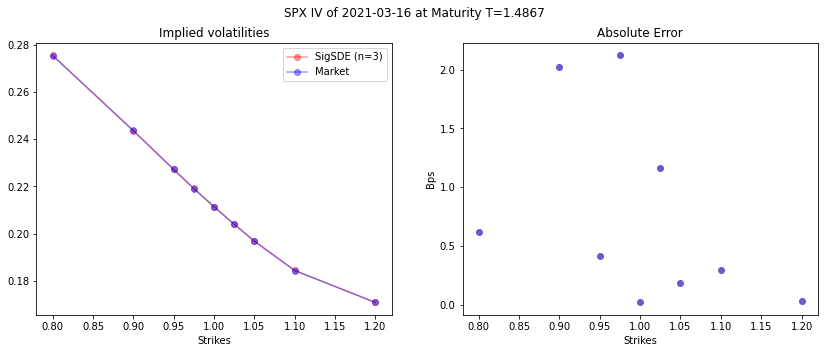

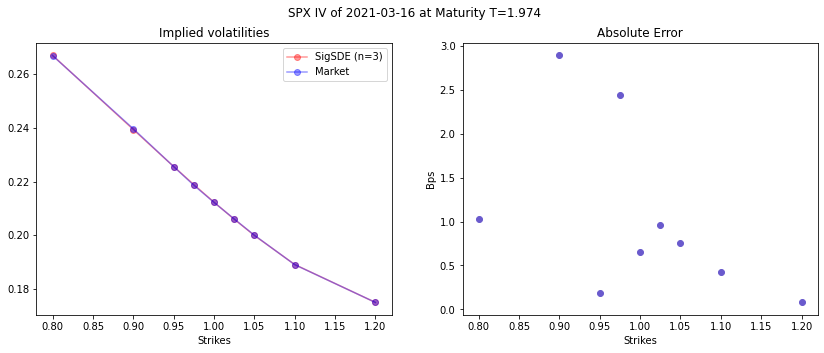

----------------------------------


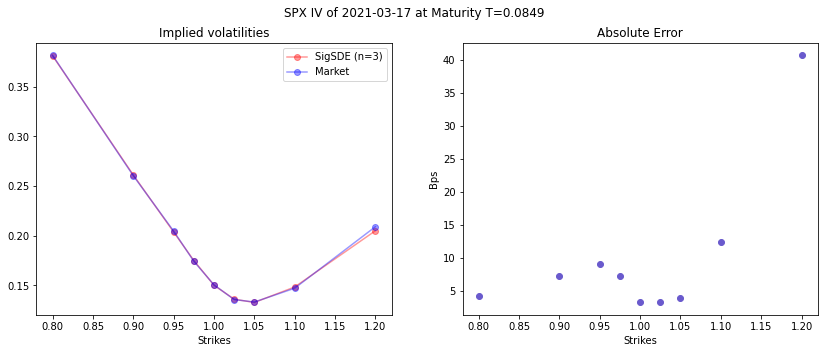

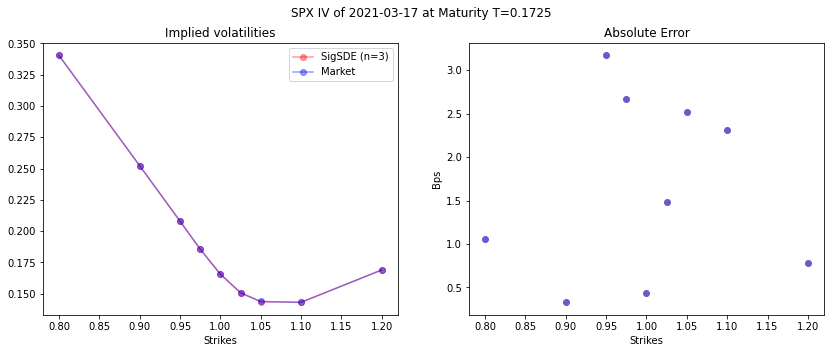

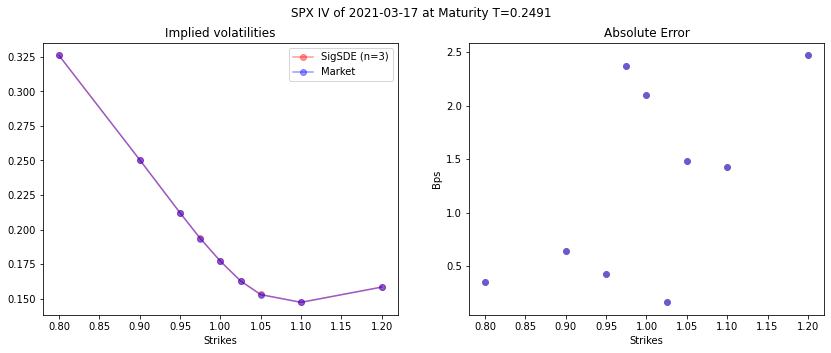

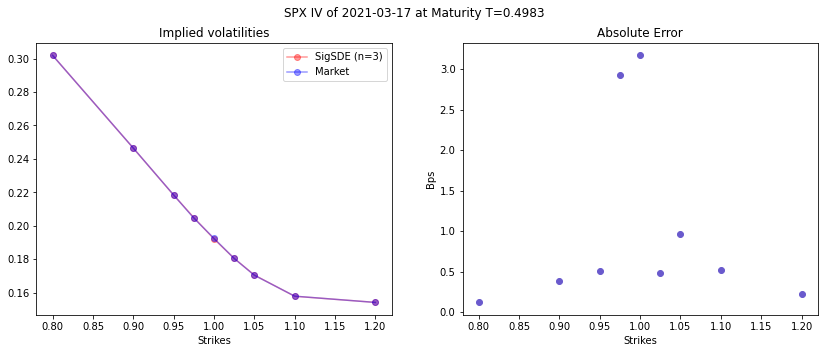

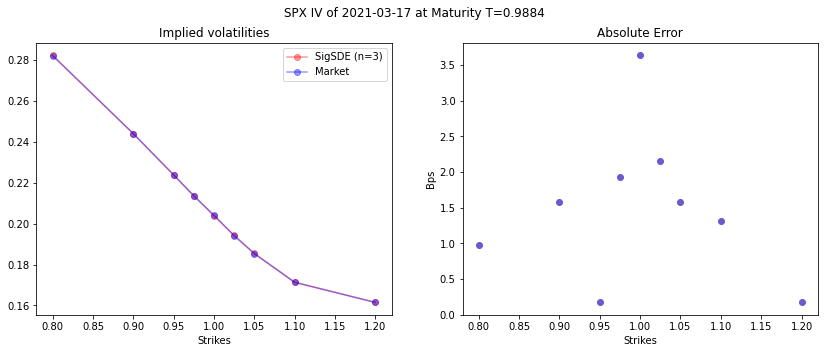

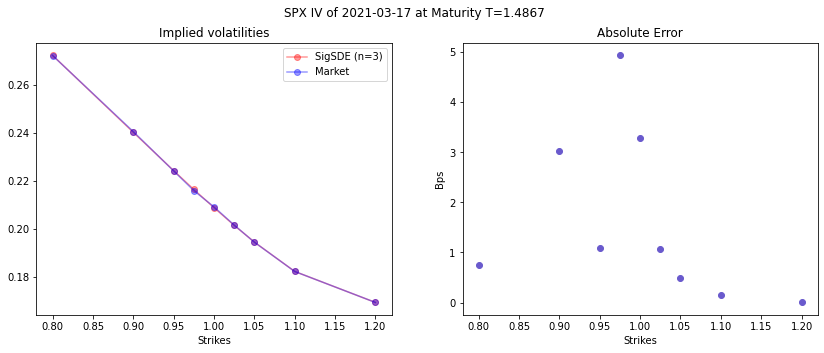

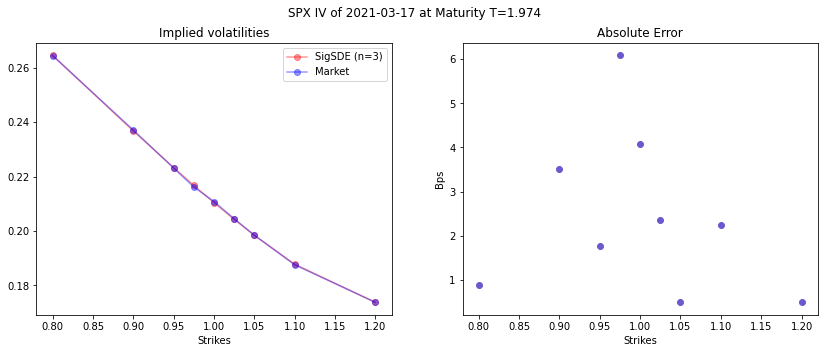

----------------------------------


In [51]:
iv_calib_history=[]
%matplotlib inline
for k in range(len(history)):
    for j in range(len(maturities)):
        iv_calib_slice,sig_prices_mc_arr_slice=get_iv_from_calib(set_calib_p[k,j,:],strikes,[maturities[j]])
        iv_calib_history.append(iv_calib_slice.squeeze(0))
iv_calib_history=np.array(iv_calib_history)
iv_calib_history=np.array(np.split(iv_calib_history,len(history),axis=0))  

for t in range(len(history)):
    for j in range(len(maturities)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
        fig.suptitle('SPX IV of '+history[t]+' at Maturity T={}'.format(round(maturities[j],4)))
        ax1.plot(strikes[0],iv_calib_history[t,j,:],marker='o',color='r',alpha=0.4,label=f'SigSDE (n=3)')
        ax1.plot(strikes[0],ivs_history[t,j,:],marker='o',color='b',alpha=0.4,label=f'Market')
        ax1.set_xlabel('Strikes')
        ax1.set_title('Implied volatilities')
        ax2.scatter(strikes[0],np.abs(iv_calib_history[t,j,:]-ivs_history[t,j,:])*10000,color='slateblue')
        ax2.set_xlabel('Strikes')
        ax2.set_ylabel('Bps')
        ax2.set_title('Absolute Error')
        ax1.legend()
        plt.show()
    print('----------------------------------')

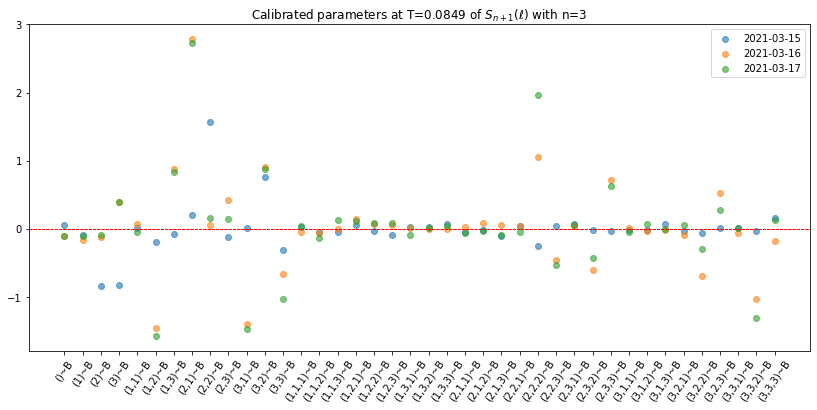

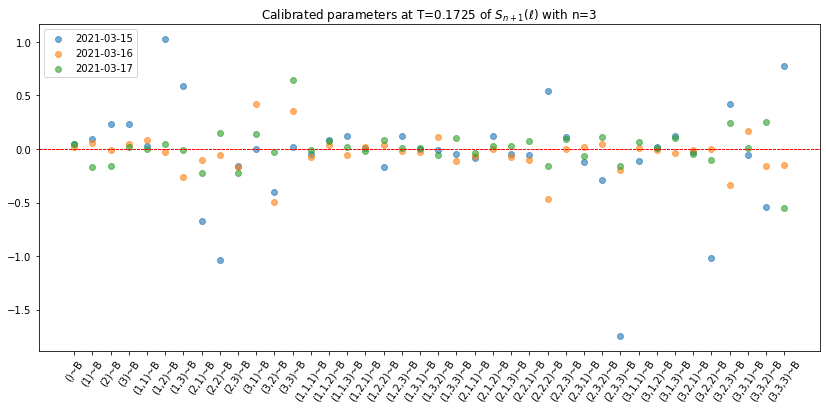

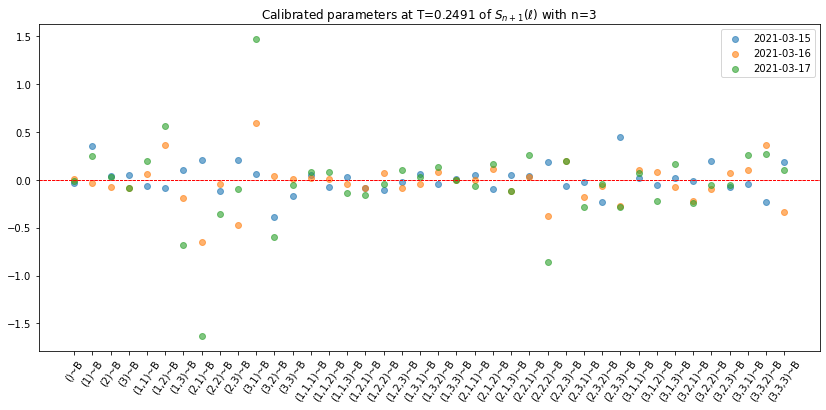

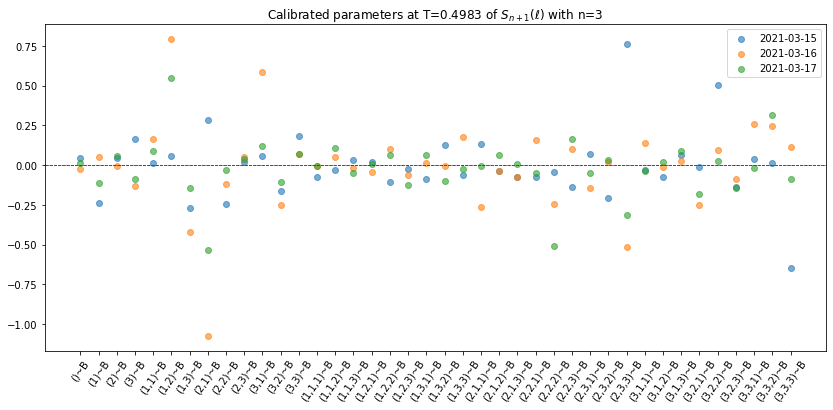

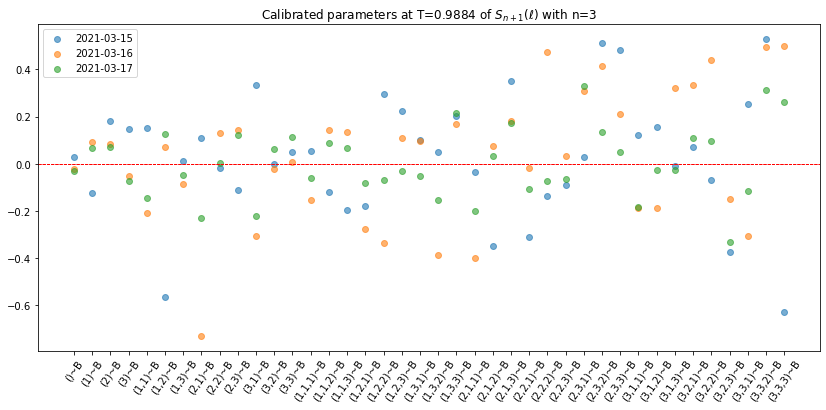

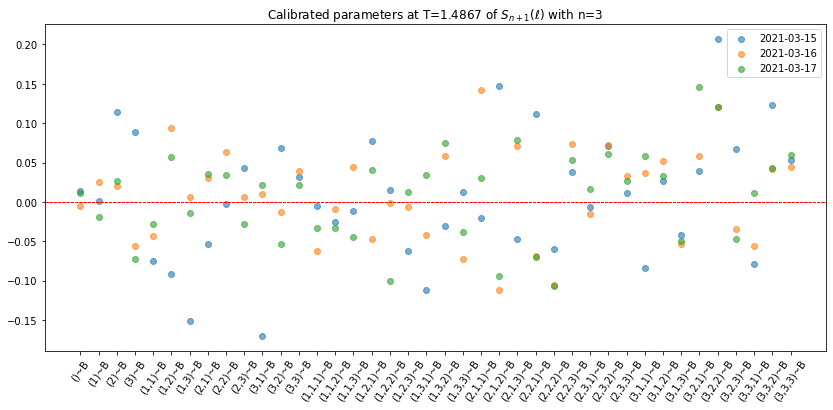

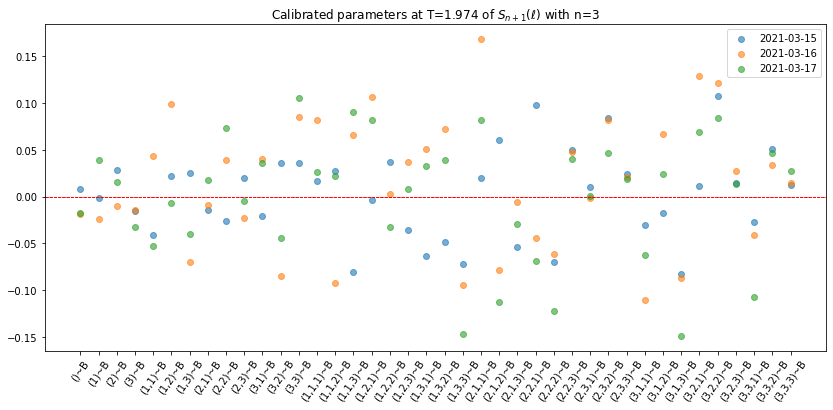

In [56]:
idx_history=[4,5,6]
chiavi=np.array([esig.sigkeys(3,n).strip('').split()[k]+str('~B') for k in range(40)])

%matplotlib inline
for j in range(len(maturities)):
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    for t in idx_history:
        ax.axhline(y=0,color='r', linestyle='--',linewidth=0.8)
        #ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='x',alpha=0.6,color='blue')
        ax.scatter(chiavi,set_calib_param[t,j,:],label=history[t],marker='o',alpha=0.6)
        plt.setp(ax.get_xticklabels(), rotation=55)
        ax.set_title(r'Calibrated parameters at T={}'.format(round(maturities[j],4))+' of $S_{n+1}(\ell)$ with'+' n={}'.format(n)) #
    ax.legend()
   # plt.savefig('Parameters_TV_all_mat.png',dpi=800)
    plt.show()